# Mini-project: K-means algorithm

## <u>Preprocessing</u>

In [ ]:
# before executing:
# pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo 
import random
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score
from scipy.stats import mode
from ucimlrepo import fetch_ucirepo

In [18]:
dataset_ids =   {
                "parkinsons": 174,
                "page-blocks": 78,
                "optical": 80,
                "musk2": 75,
                "bc-wisc-diag": 17,
                "students": 697,
                "wine": 109,
                "magic": 159,
                "balance-scale": 12,
                "glass": 42,
                "zoo": 111,
                "waveform": 107,
                "image-segmentation": 50,
                "blood": 176,
                "spect": 95,
                "yeast": 110,
                "monk": 70,
                "ecoli": 39,
                "iris": 53,
                "contraception": 30,
                "fertility": 244,
                "conn-bench-sonar":  151,
                "landsat": 146,
                "ionosphere": 52,
                "letter": 59,
                }

In [7]:
def load_dataset(id):  
    # fetch dataset 
    dataset = fetch_ucirepo(id=id) 
    
    # data (as pandas dataframes) 
    X = dataset.data.features 
    y =dataset.data.targets 
    
    # dictionary gthering infos about the metadata (url, abstract, ... etc.)
    metadata_infos_dict = dataset.metadata
    print('data url:\n', metadata_infos_dict['data_url'])
    
    # variable information
    var_infos = dataset.variables.to_numpy()
    
    data_vectors = X.to_numpy() #instance vectors with features
    features_names = X.columns.to_numpy() #getting the names of each feature
    
    data_labels = y.to_numpy() #output labels for each instance
    label_name = y.columns.to_numpy() # name of the output label
    
    return data_vectors, features_names, data_labels, label_name

In [8]:
def print_useful_data(X, X_names, y, y_name, index = 0):
    n_instances = len(X)
    n_features = len(X_names)
    
    print("number of instances: ", n_instances)
    print("number of features: ", n_features)

    print("names of the features:\n", X_names) #features' names
    print("name of the output label: ", y_name)

    print(f"instance {index} feature vector:\n", X[index])
    print(f"instance {index} output label: ", y[index])

In [9]:
def preprocessing(X, y, split = 0.7):
    scaler = StandardScaler()
    try:
        #standardization
        X = scaler.fit_transform(X)
    except ValueError:
        #If non numerical data is detected, data is encoded
        X = np.array(X, dtype=object) 
        encoder = OneHotEncoder()
        X_encoded = encoder.fit_transform(X).toarray()
        X = scaler.fit_transform(X_encoded)  
    
    #data is split among training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=split, random_state=42)
    
    return X_train, Y_train, X_test, Y_test

## <u>K-means core algorithm and cross validation</u>

In [10]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [11]:
#main body, centroids and clusters are computed until convergence is reached
def k_means(X, k, max_iters=100, tol=1e-4, visualization = True, display_iteration = 8):
    #at first centroids are initialized at random
    np.random.seed(42)
    centroids = X[random.sample(range(X.shape[0]), k)]

    for iteration in range(max_iters):
        #clusters are assigned based on closest centroids
        clusters = [[] for _ in range(k)]
        for idx, point in enumerate(X):
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(idx)

        #centroids are updated by calculating the mean of assigned points
        new_centroids = np.zeros_like(centroids)
        for i, cluster in enumerate(clusters):
            if cluster:
                new_centroids[i] = np.mean(X[cluster], axis=0)
            else:
                new_centroids[i] = centroids[i]  #avoid empty cluster
        
        #visualization of clusters and centroids every 8 iterations (or chosen value of display_iteration)
        if iteration%display_iteration == 0 and visualization == True:
            cluster_labels = np.zeros(X.shape[0])
            for cluster_idx, cluster in enumerate(clusters):
                for point_idx in cluster:
                    cluster_labels[point_idx] = cluster_idx
            visualize_clusters(X, clusters, new_centroids, iteration + 1, k, cluster_labels)


        #convergence check
        convergence = np.linalg.norm(new_centroids - centroids)
        if convergence < tol:
            break

        centroids = new_centroids

    # final centroids and cluster assignments
    cluster_labels = np.zeros(X.shape[0])
    for cluster_idx, cluster in enumerate(clusters):
        for point_idx in cluster:
            cluster_labels[point_idx] = cluster_idx

    return centroids, cluster_labels

In [12]:
#cross-validation function to select the best k
def cross_validation(X, y, k_values, n_splits=5):
    best_k = None
    best_accuracy = -1
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for k in k_values:
        accuracies = []

        #cross-validation is done for iterated k
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            #K-means on the folded sets
            centroids, cluster_labels = k_means(X_train, k, visualization = False)

            #clusters prediction on the validation set
            cluster_labels_val = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_val])

            #accuracy on the validation set
            accuracy, f1, cm = calculate_metrics(cluster_labels_val, y_val, compute_f1_cm = False)
            accuracies.append(accuracy)

        #calculate the accuracy for the iterated k
        avg_accuracy = np.mean(accuracies)
        print(f"predicted accuracy for k={k}: {avg_accuracy * 100:.2f}%")

        #keeps in memory the best k based on accuracy 
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_k = k

    return best_k

## <u>Visualization function</u>

In [13]:
#function to visualize clusters using PCA
def visualize_clusters(X, clusters, centroids, iteration, nb_cluster, cluster_labels=None):
    plt.figure(figsize=(8, 6))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  #define colors for clusters

    #reduce the data to 2D using PCA for visualization
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X) 

    #if cluster assignments are provided, color by cluster membership
    if cluster_labels is not None:
        for i in range(nb_cluster):
            cluster_points_2D = X_2D[cluster_labels == i]
            plt.scatter(cluster_points_2D[:, 0], cluster_points_2D[:, 1], 
                        color=colors[i % len(colors)], label=f'Cluster {i+1}')
    else:
        for i, cluster in enumerate(clusters):
            cluster_points = np.array(cluster)
            cluster_points_2D = pca.transform(cluster_points)  #transform current cluster into 2D
            plt.scatter(cluster_points_2D[:, 0], cluster_points_2D[:, 1], 
                        color=colors[i % len(colors)], label=f'Cluster {i+1}')

    #plot centroids in 2D space
    centroids_2D = pca.transform(centroids)  #transform centroids into 2D
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                color='black', marker='x', s=200, label='Centroids')

    plt.title(f"clusters and centroids - Iteration {iteration}")
    plt.legend()
    plt.show()

## <u>Accuracy, F1 and confusion matrice</u>

In [14]:
def calculate_metrics(cluster_labels, true_labels, compute_f1_cm = True):
    unique_labels = np.unique(true_labels)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_int[label] for label in true_labels.ravel()])

    #map clusters to most frequent true labels
    cluster_to_label = {}
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        if np.any(mask):
            most_common_label, _ = mode(int_labels[mask], axis=None)
            cluster_to_label[cluster] = most_common_label.item()  
        else:
            cluster_to_label[cluster] = -1  #avoid empty clusters

    #predicted labels
    predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_labels])

    #compute accuracy
    accuracy = np.mean(predicted_labels == int_labels)
    
    f1 = None
    cm = None
    if compute_f1_cm == True: 
        #compute F1 score
        f1 = f1_score(int_labels, predicted_labels, average='macro')
    
        #compute confusion matrix
        cm = confusion_matrix(int_labels, predicted_labels)

    return accuracy, f1, cm

## <u>Results on 25 datasets</u>

### Predict Students' Dropout and Academic Success

In [12]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["students"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/697/data.csv
training set size: (3096, 36)
testing set size: (1328, 36)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;30]
predicted accuracy for k=2: 54.10%
predicted accuracy for k=3: 64.96%
predicted accuracy for k=4: 63.92%
predicted accuracy for k=5: 63.95%
predicted accuracy for k=6: 62.95%
predicted accuracy for k=7: 63.02%
predicted accuracy for k=8: 63.34%
predicted accuracy for k=9: 64.15%
predicted accuracy for k=10: 64.21%
predicted accuracy for k=11: 65.99%
predicted accuracy for k=12: 64.24%
predicted accuracy for k=13: 65.96%
predicted accuracy for k=14: 65.08%
predicted accuracy for k=15: 65.83%
predicted accuracy for k=16: 66.34%
predicted accuracy for k=17: 66.73%
predicted accuracy for k=18: 66.21%
predicted accuracy for k=19: 66.38%
predicted accuracy for k=20: 67.67%
predicted accuracy for k=21: 67.15%
predicted accuracy for k=22: 66.57%
predicted accuracy for k=23: 66.47%
predicted accuracy for k=24: 66.63%
predicted accuracy for k=25: 66.76%
predicted accuracy for k=26: 66.41%
predicted accuracy for k=27: 67.31%
predicted accuracy for k=28: 66.51%
pre

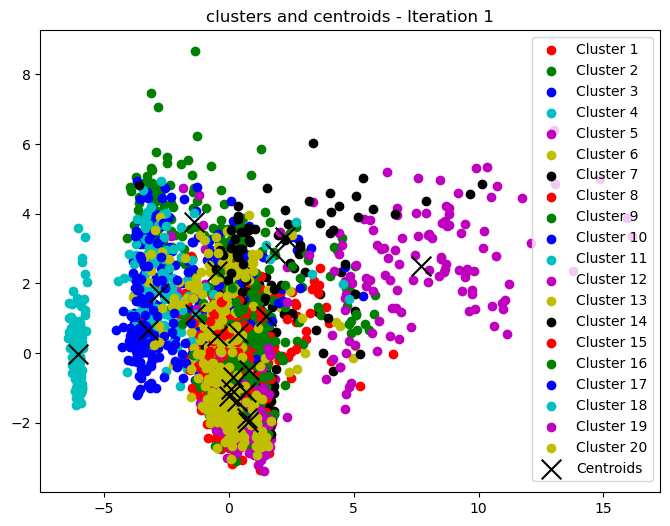

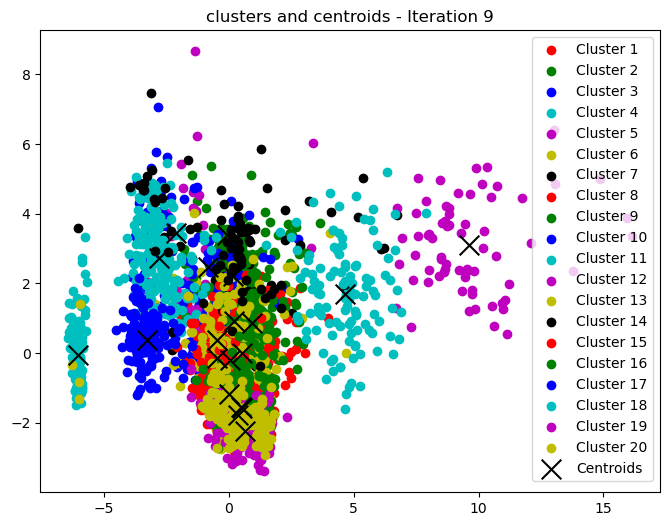

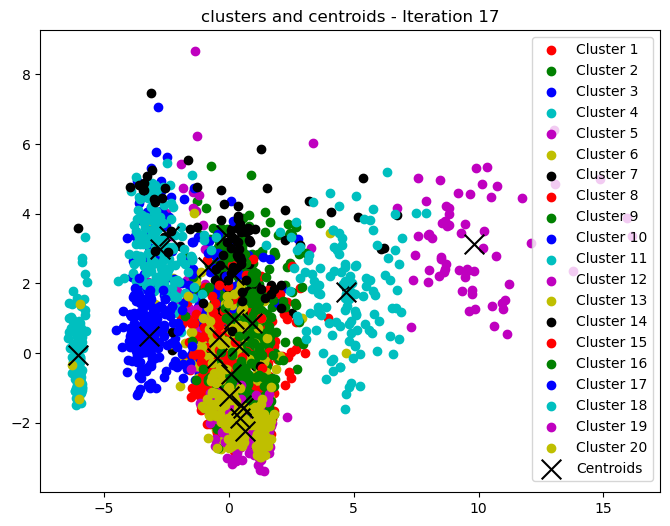

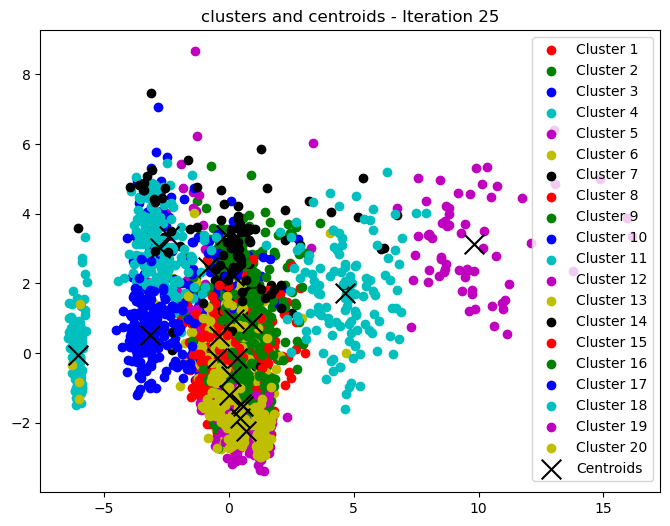

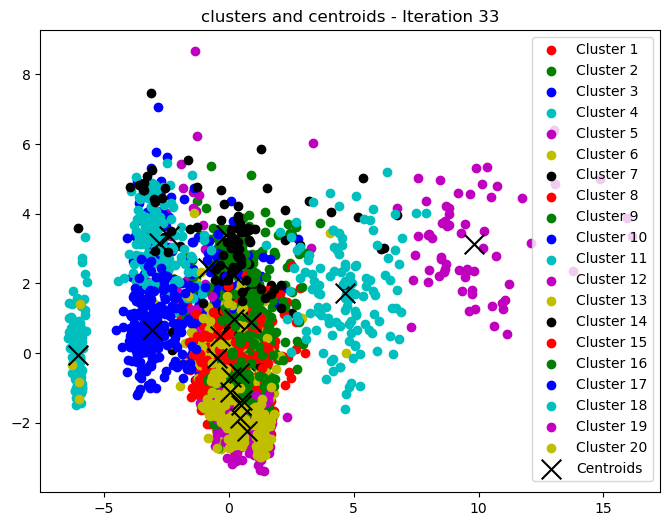

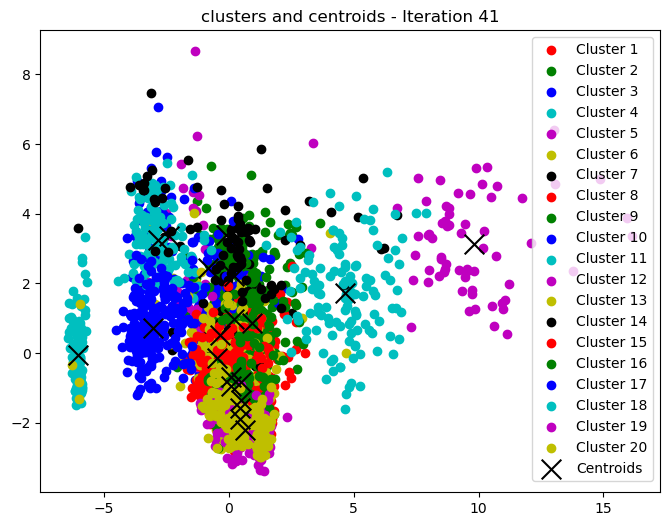

accuracy: 63.40%
F1 score: 0.45
confusion matrix:
[[252   0 213]
 [ 33   0 205]
 [ 35   0 590]]


In [19]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Wine

In [89]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["wine"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/109/data.csv
training set size: (124, 13)
testing set size: (54, 13)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 56.50%
predicted accuracy for k=3: 87.97%
predicted accuracy for k=4: 96.77%
predicted accuracy for k=5: 95.97%
predicted accuracy for k=6: 92.77%
predicted accuracy for k=7: 95.93%
predicted accuracy for k=8: 93.53%
predicted accuracy for k=9: 95.97%
predicted accuracy for k=10: 96.77%
the best value of k is 4


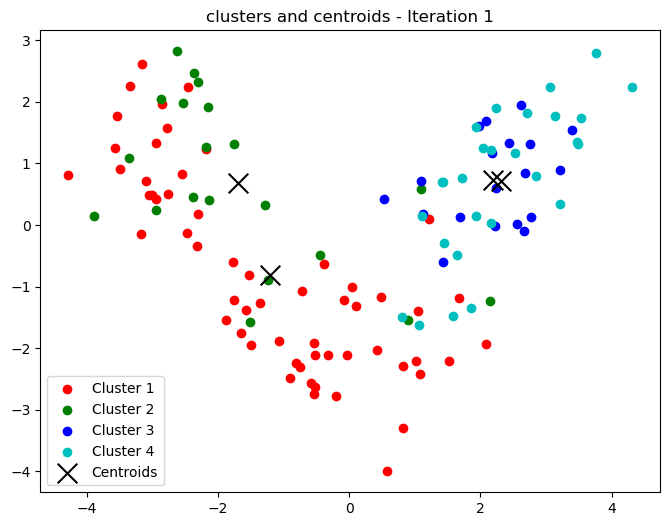

accuracy: 98.15%
F1 score: 0.98
confusion matrix:
[[19  0  0]
 [ 0 20  1]
 [ 0  0 14]]


In [90]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### MAGIC gamma telescope

In [118]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["magic"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)

num_sample = 2500
X_train, X_test = X_train[:num_sample*2,:], X_test[:num_sample,:]
Y_train, Y_test = Y_train[:num_sample*2], Y_test[:num_sample]

print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/159/data.csv
training set size: (5000, 10)
testing set size: (2500, 10)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;30]
predicted accuracy for k=2: 64.82%
predicted accuracy for k=3: 71.16%
predicted accuracy for k=4: 70.36%
predicted accuracy for k=5: 74.54%
predicted accuracy for k=6: 74.54%
predicted accuracy for k=7: 74.54%
predicted accuracy for k=8: 74.04%
predicted accuracy for k=9: 74.80%
predicted accuracy for k=10: 74.64%
predicted accuracy for k=11: 75.14%
predicted accuracy for k=12: 75.54%
predicted accuracy for k=13: 76.44%
predicted accuracy for k=14: 76.26%
predicted accuracy for k=15: 77.16%
predicted accuracy for k=16: 76.60%
predicted accuracy for k=17: 76.70%
predicted accuracy for k=18: 77.98%
predicted accuracy for k=19: 77.58%
predicted accuracy for k=20: 77.10%
predicted accuracy for k=21: 77.68%
predicted accuracy for k=22: 76.68%
predicted accuracy for k=23: 77.40%
predicted accuracy for k=24: 77.10%
predicted accuracy for k=25: 77.60%
predicted accuracy for k=26: 77.78%
predicted accuracy for k=27: 77.24%
predicted accuracy for k=28: 78.48%
pre

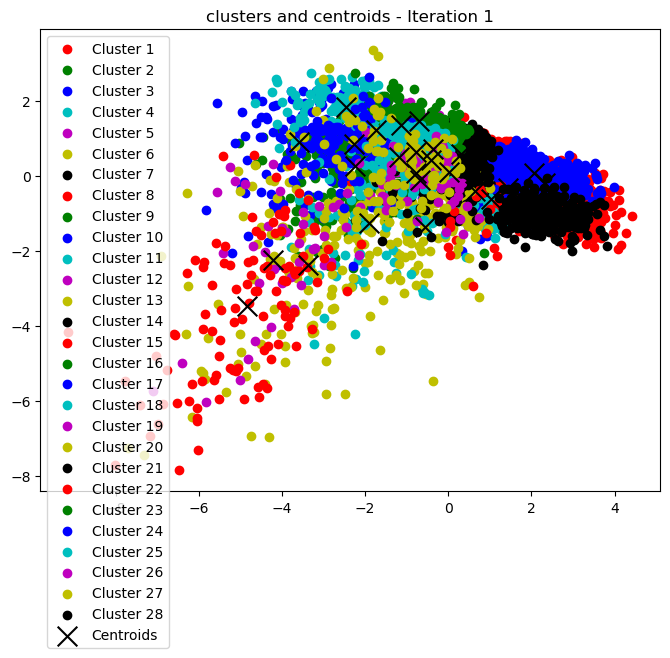

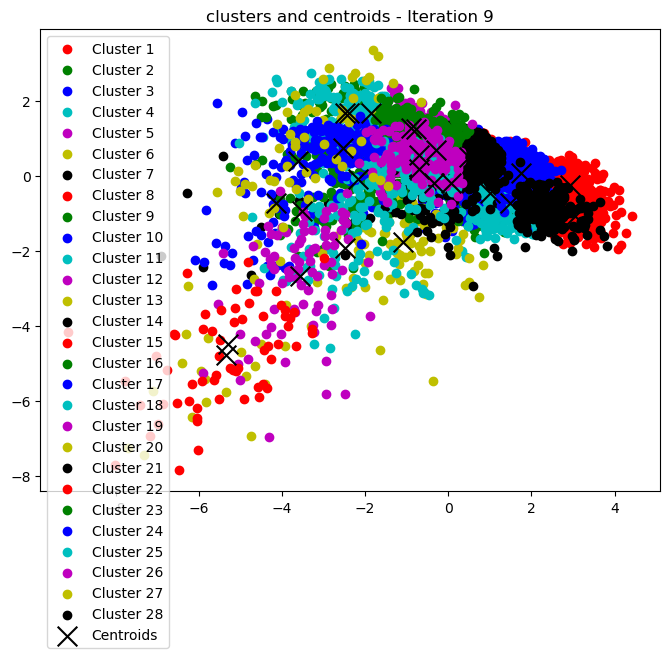

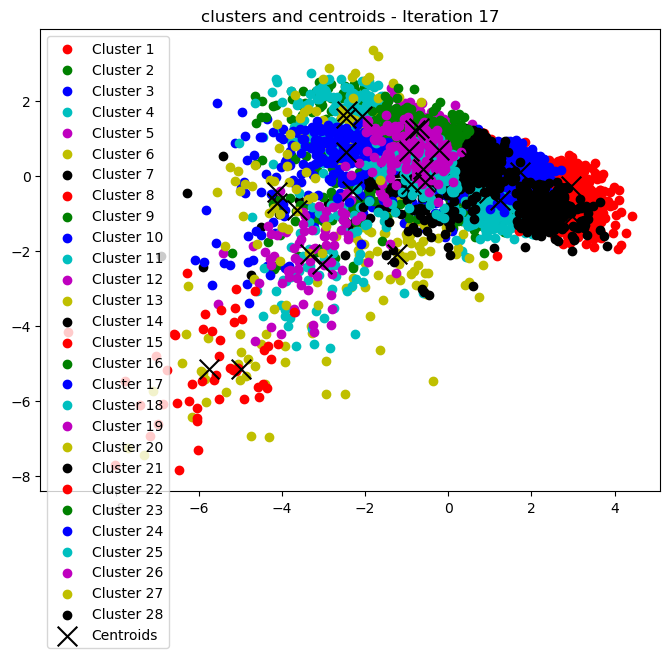

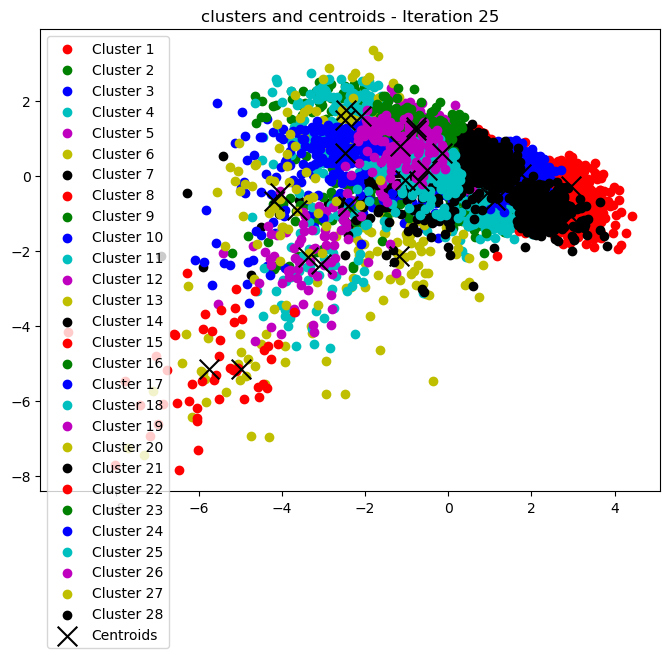

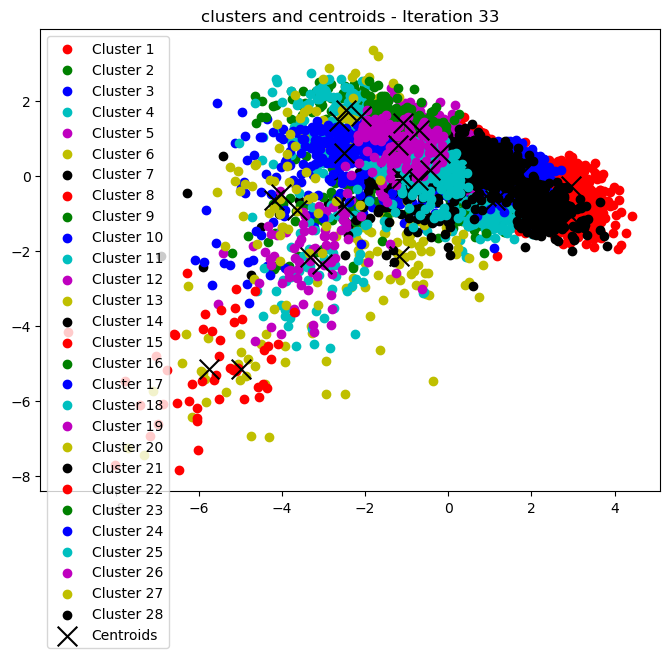

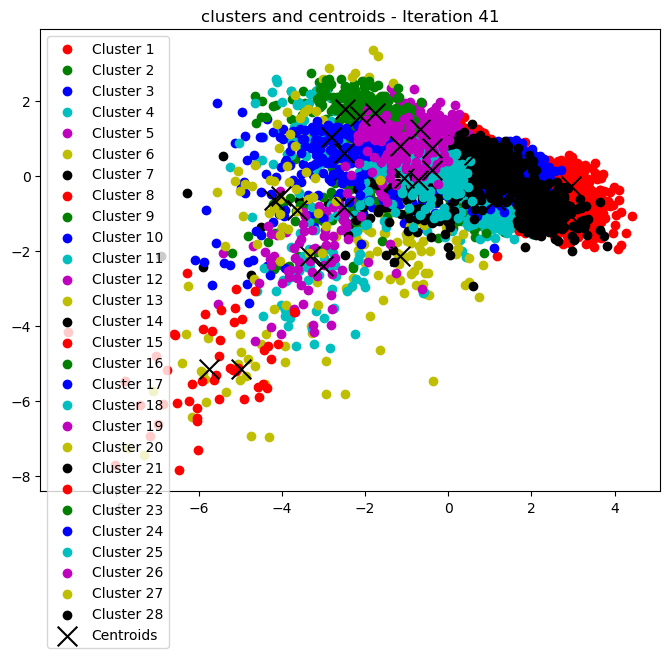

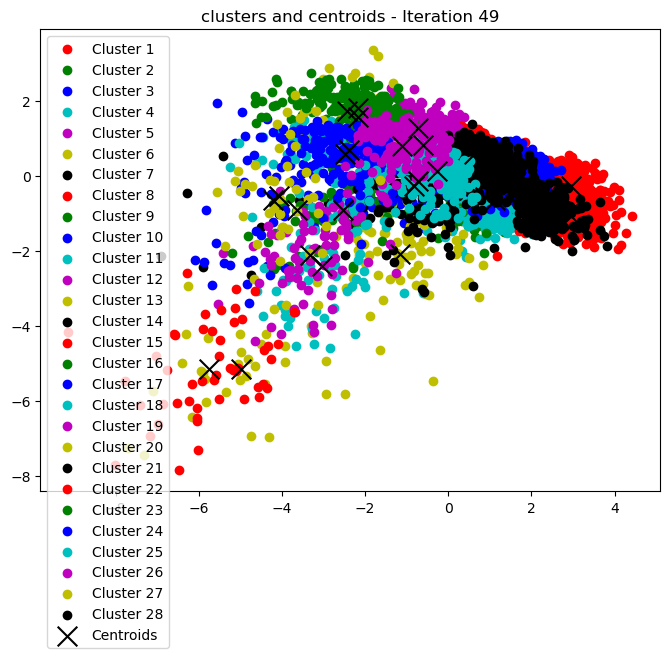

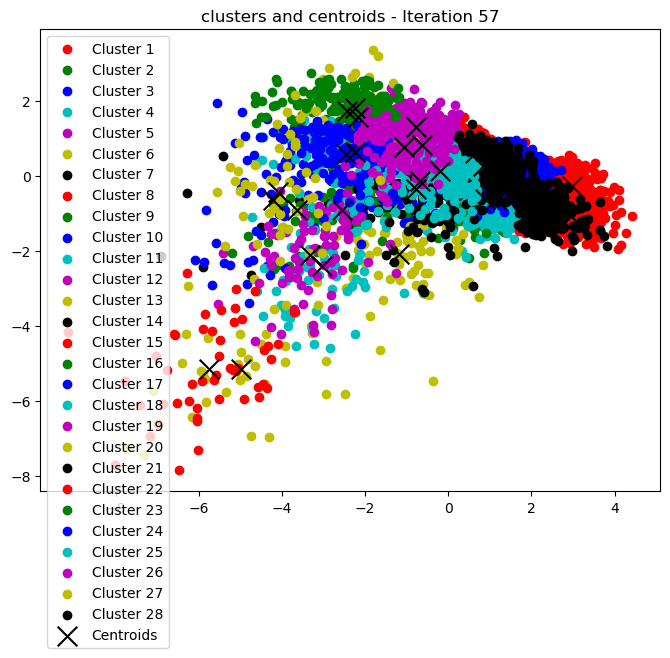

accuracy: 78.72%
F1 score: 0.73
confusion matrix:
[[1551   69]
 [ 463  417]]


In [119]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values, 3)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Parkinsons

In [19]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["parkinsons"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/174/data.csv
training set size: (136, 22)
testing set size: (59, 22)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 75.77%
predicted accuracy for k=3: 77.99%
predicted accuracy for k=4: 80.21%
predicted accuracy for k=5: 82.43%
predicted accuracy for k=6: 81.69%
predicted accuracy for k=7: 86.80%
predicted accuracy for k=8: 88.25%
predicted accuracy for k=9: 87.51%
predicted accuracy for k=10: 91.22%
the best value of k is 10


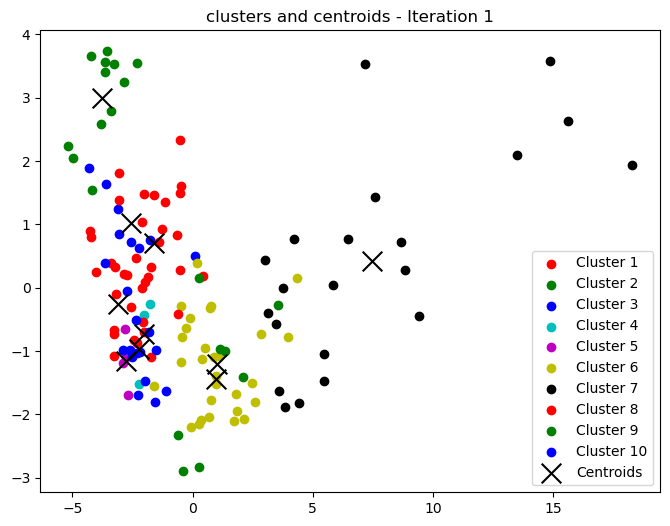

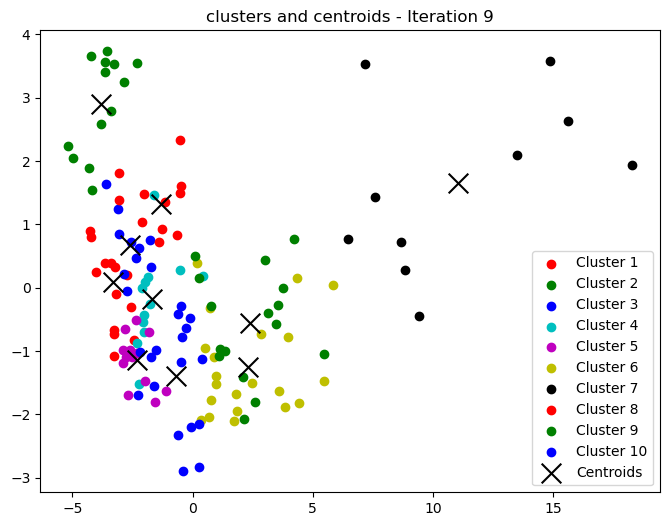

accuracy: 88.14%
F1 score: 0.82
confusion matrix:
[[ 9  6]
 [ 1 43]]


In [20]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Page-blocks

In [21]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["page-blocks"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/78/data.csv
training set size: (3831, 10)
testing set size: (1642, 10)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;30]
predicted accuracy for k=2: 89.98%
predicted accuracy for k=3: 90.68%
predicted accuracy for k=4: 90.60%
predicted accuracy for k=5: 91.52%
predicted accuracy for k=6: 91.57%
predicted accuracy for k=7: 91.39%
predicted accuracy for k=8: 91.78%
predicted accuracy for k=9: 92.01%
predicted accuracy for k=10: 92.20%
predicted accuracy for k=11: 92.59%
predicted accuracy for k=12: 92.33%
predicted accuracy for k=13: 92.51%
predicted accuracy for k=14: 92.53%
predicted accuracy for k=15: 92.64%
predicted accuracy for k=16: 92.64%
predicted accuracy for k=17: 92.59%
predicted accuracy for k=18: 92.95%
predicted accuracy for k=19: 93.00%
predicted accuracy for k=20: 92.82%
predicted accuracy for k=21: 92.80%
predicted accuracy for k=22: 93.24%
predicted accuracy for k=23: 92.85%
predicted accuracy for k=24: 92.98%
predicted accuracy for k=25: 93.14%
predicted accuracy for k=26: 93.27%
predicted accuracy for k=27: 93.19%
predicted accuracy for k=28: 93.32%
pre

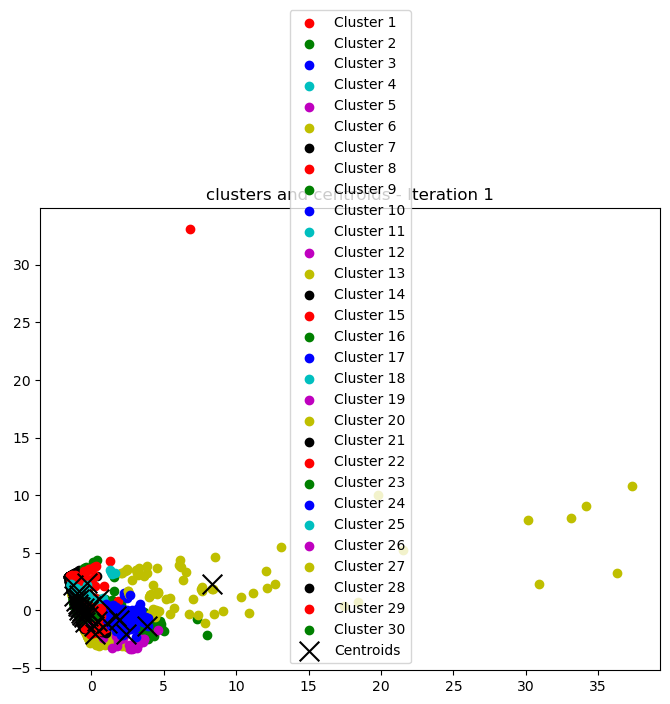

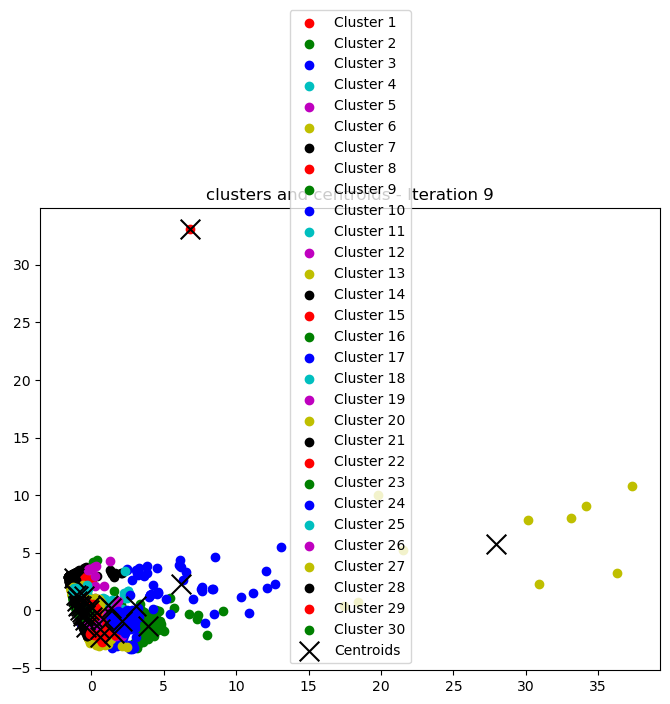

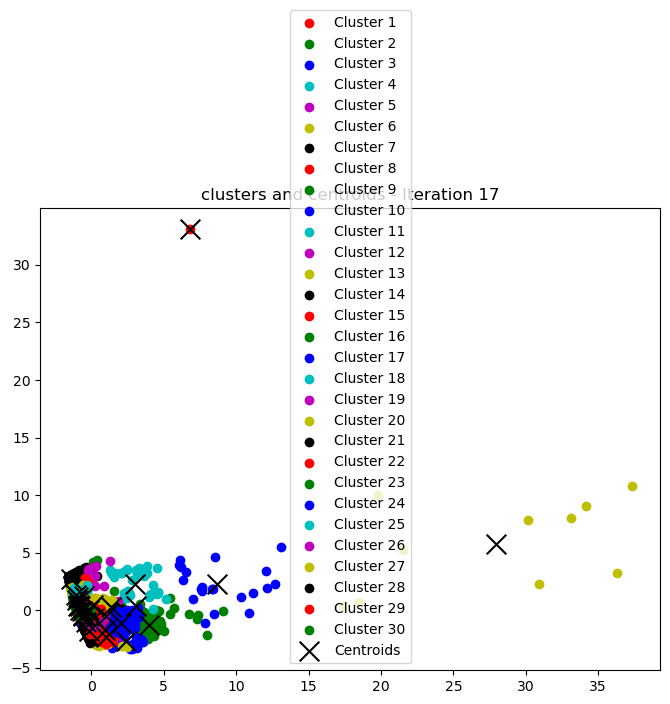

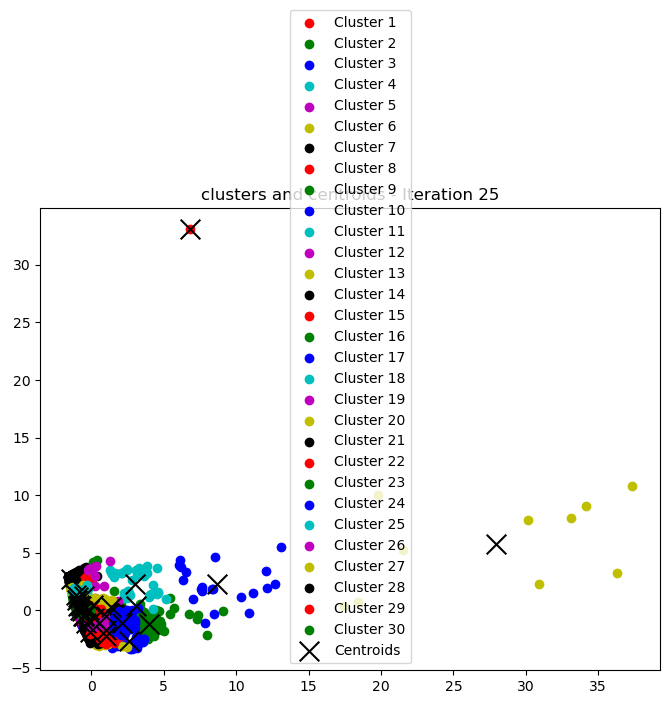

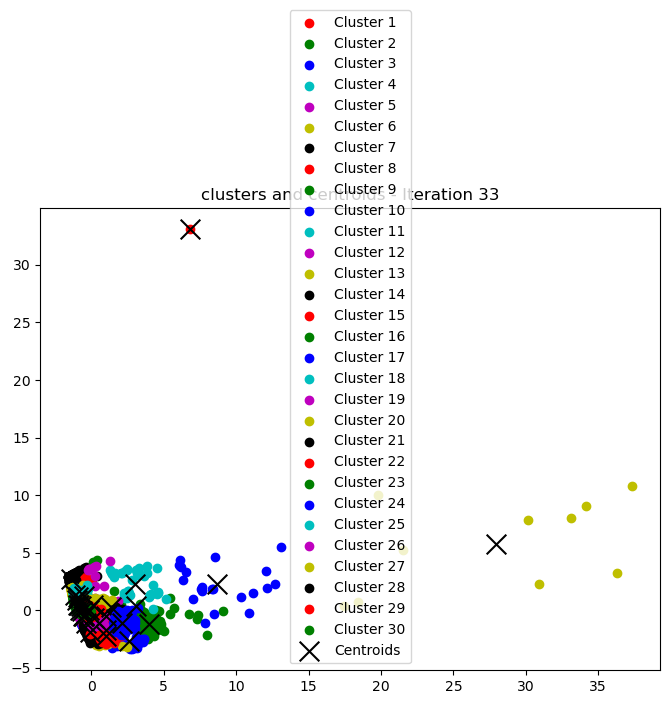

accuracy: 92.75%
F1 score: 0.45
confusion matrix:
[[1448   14    0    2    2]
 [  40   65    0    0    1]
 [   7    0    1    2    0]
 [   6   20    0    4    1]
 [  22    0    1    1    5]]


In [22]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Optical

In [24]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["optical"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)

print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/80/data.csv
training set size: (3933, 64)
testing set size: (1687, 64)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;30]
predicted accuracy for k=2: 21.36%
predicted accuracy for k=3: 29.57%
predicted accuracy for k=4: 38.04%
predicted accuracy for k=5: 45.31%
predicted accuracy for k=6: 48.59%
predicted accuracy for k=7: 52.61%
predicted accuracy for k=8: 60.90%
predicted accuracy for k=9: 62.57%
predicted accuracy for k=10: 64.33%
predicted accuracy for k=11: 71.78%
predicted accuracy for k=12: 71.90%
predicted accuracy for k=13: 74.09%
predicted accuracy for k=14: 76.28%
predicted accuracy for k=15: 81.49%
predicted accuracy for k=16: 76.64%
predicted accuracy for k=17: 84.11%
predicted accuracy for k=18: 81.59%
predicted accuracy for k=19: 85.15%
predicted accuracy for k=20: 83.47%
predicted accuracy for k=21: 86.09%
predicted accuracy for k=22: 85.71%
predicted accuracy for k=23: 86.02%
predicted accuracy for k=24: 85.15%
predicted accuracy for k=25: 86.27%
predicted accuracy for k=26: 86.63%
predicted accuracy for k=27: 86.75%
predicted accuracy for k=28: 87.06%
pre

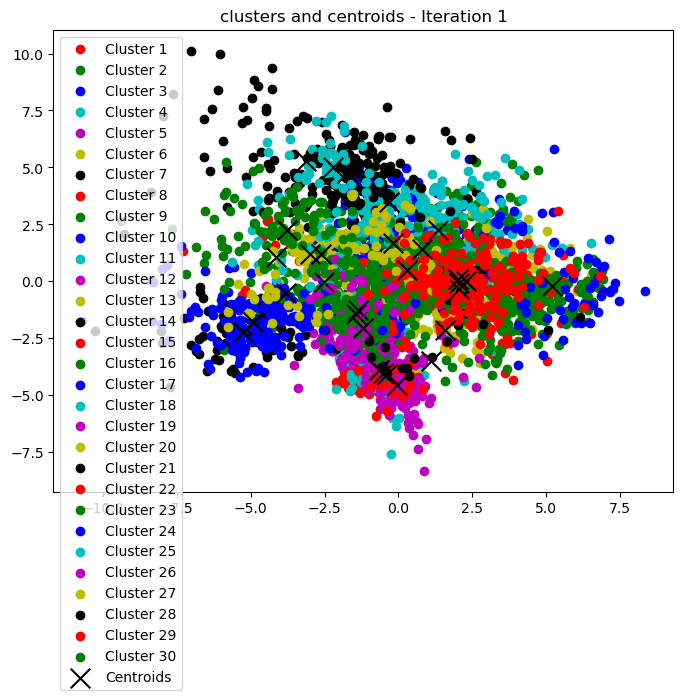

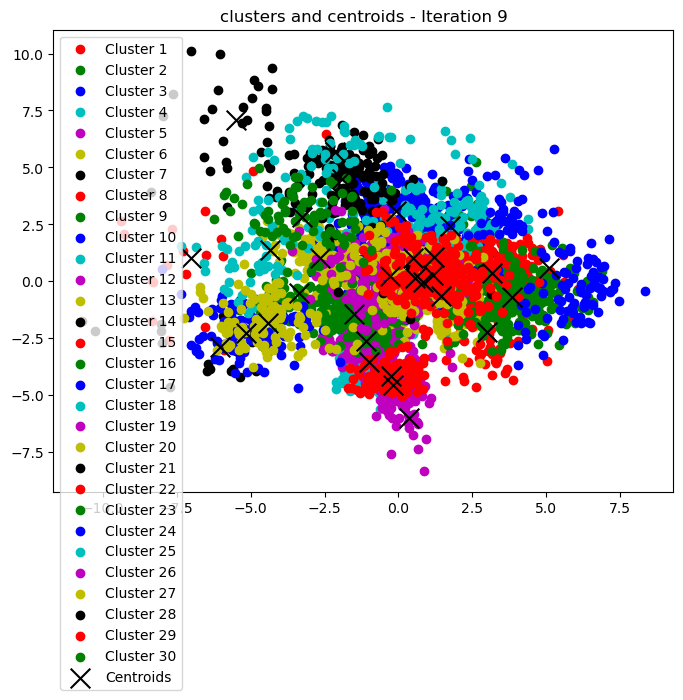

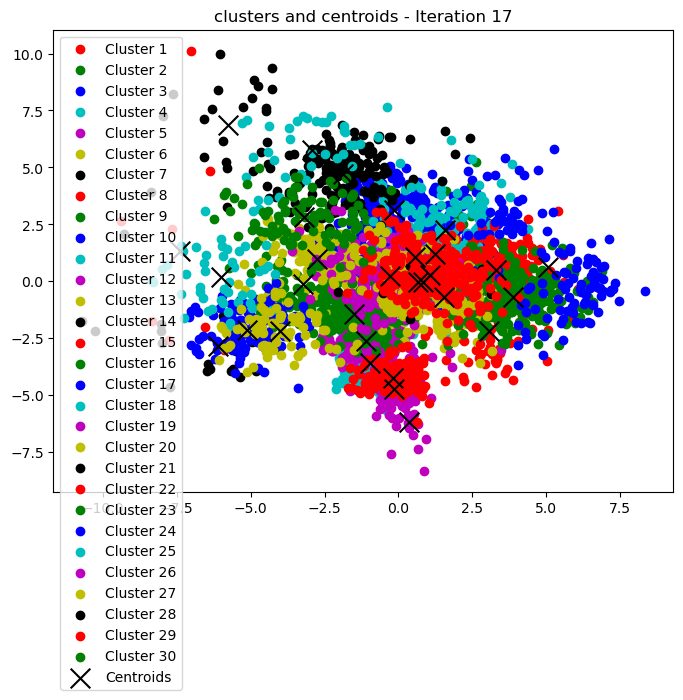

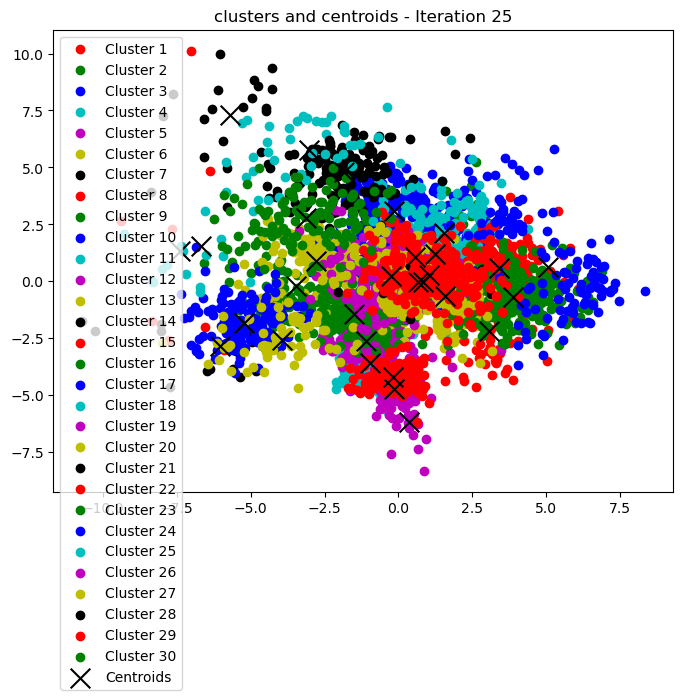

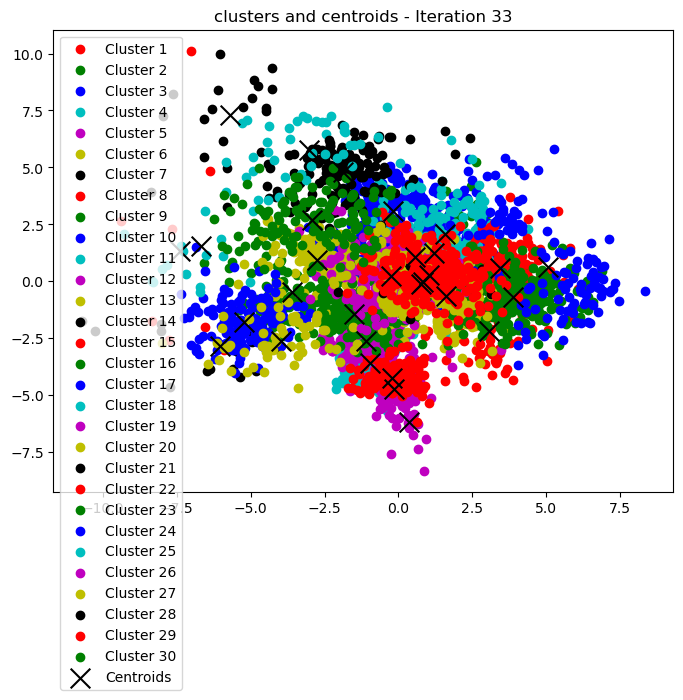

accuracy: 86.01%
F1 score: 0.86
confusion matrix:
[[167   0   1   0   1   0   1   0   0   0]
 [  0 168   1   0   0   0   1   0   2   1]
 [  0  18 110   1   1   0   0   2  19   3]
 [  0   1   5 134   0   2   0   5   4  22]
 [  0   5   1   0 160   0   2   7   3   5]
 [  0   1   7   5   1  97   0   1   3  38]
 [  0   2   0   0   0   0 166   0   0   0]
 [  0   3   4   1   2   0   0 173   1   2]
 [  0  12   1   3   1   0   0   0 128   8]
 [  0   2   0   8   4   2   0   4   6 148]]


In [26]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Ionosphere

In [57]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["ionosphere"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/52/data.csv
training set size: (245, 34)
testing set size: (106, 34)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;13]
predicted accuracy for k=2: 71.43%
predicted accuracy for k=3: 76.73%
predicted accuracy for k=4: 75.10%
predicted accuracy for k=5: 76.33%
predicted accuracy for k=6: 76.73%
predicted accuracy for k=7: 80.00%
predicted accuracy for k=8: 80.82%
predicted accuracy for k=9: 80.82%
predicted accuracy for k=10: 78.37%
predicted accuracy for k=11: 78.78%
predicted accuracy for k=12: 80.82%
predicted accuracy for k=13: 80.00%
the best value of k is 9


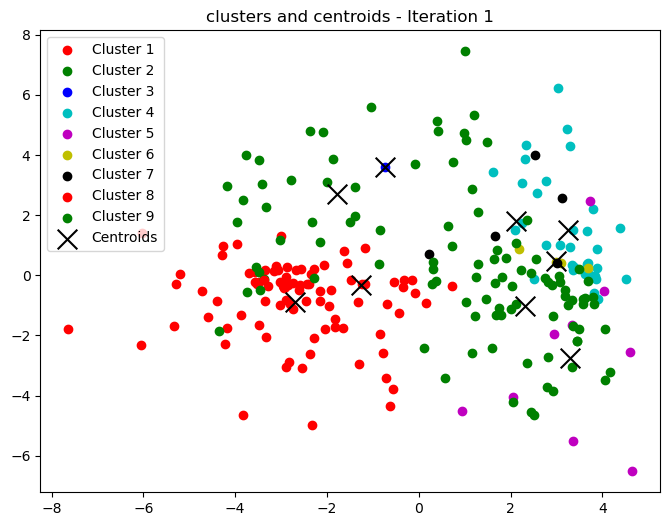

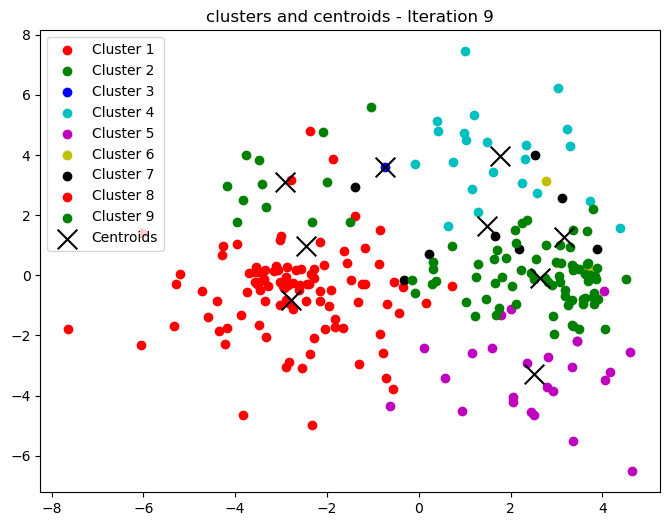

accuracy: 97.17%
F1 score: 0.69
confusion matrix:
[[  1   3]
 [  0 102]]


In [58]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Glass Identification

In [53]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["glass"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/42/data.csv
training set size: (149, 9)
testing set size: (65, 9)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 58.41%
predicted accuracy for k=3: 57.08%
predicted accuracy for k=4: 64.41%
predicted accuracy for k=5: 64.44%
predicted accuracy for k=6: 75.17%
predicted accuracy for k=7: 71.15%
predicted accuracy for k=8: 71.20%
predicted accuracy for k=9: 79.84%
predicted accuracy for k=10: 77.91%
the best value of k is 9


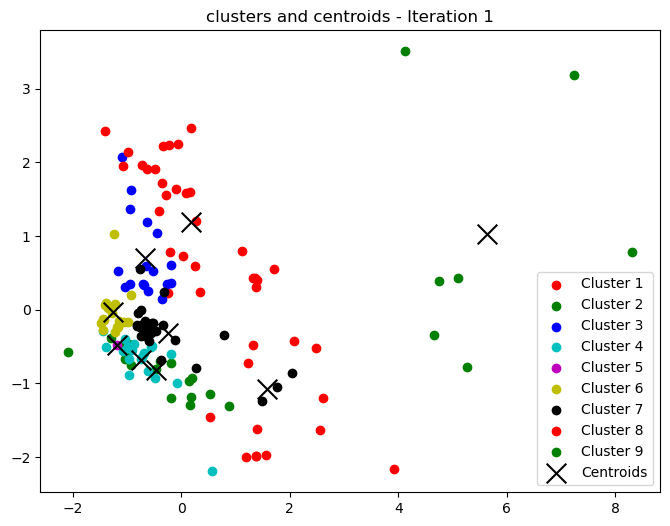

accuracy: 73.85%
F1 score: 0.70
confusion matrix:
[[10  2  2  0]
 [ 2  8  0  3]
 [ 1  0  6  2]
 [ 1  1  3 24]]


In [56]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Letter Recognition

In [110]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["letter"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/59/data.csv
training set size: (14000, 16)
testing set size: (6000, 16)


In [ ]:
print_useful_data(X, X_names, y, y_name)

In [112]:
k = 600 #After testing a few values for this complex dataset, the best value of k is much higher than 30 (30 gives around 30% accuracy). k higher than 600 could increase accuracy but also lead to overfitting.
#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, k, visualization = False)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

accuracy: 81.13%
F1 score: 0.81
confusion matrix:
[[223   0   0   1   0   0   0   2   1   0   0   0   1   0   0   0   0   2
    0   2   0   0   0   0   0   0]
 [  0 181   0   6   4   0   0   4   1   0   1   0   0   4   1   0   0  22
    1   1   1   0   0   1   0   1]
 [  0   0 157   0  19   2   7   0   0   0   0   1   1   0   4   0   2   0
    0   3   5   0   0   0   0   0]
 [  2   6   0 204   0   0   0   6   1   3   0   0   0   4   0   0   0   7
    5   0   3   0   0   4   2   3]
 [  0   3   6   0 181   4   8   4   0   0   4   1   0   0   0   0   2   1
    6   0   0   0   0  12   0   6]
 [  0   3   0   1   0 169   0   1   0   4   0   0   0   1   1  19   0   0
    2   8   0   0   0   0   0   2]
 [  0   6   7   1   3   0 185   4   0   0   1   2   0   1   6   0   3   1
    6   0   1   0   1   0   0   2]
 [  1   6   1   9   1   1   5 137   0   0   6   0   3  12   4   2   1  13
    2   0   2   1   0   6   3   2]
 [  0   0   0   4   0   3   0   0 191  12   2   0   0   0   0   0   1   0
    

### Connectionist Bench (Sonar, Mines vs. Rocks)

In [94]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["conn-bench-sonar"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/151/data.csv
training set size: (145, 60)
testing set size: (63, 60)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 60.69%
predicted accuracy for k=3: 62.76%
predicted accuracy for k=4: 69.66%
predicted accuracy for k=5: 64.83%
predicted accuracy for k=6: 64.14%
predicted accuracy for k=7: 69.66%
predicted accuracy for k=8: 71.72%
predicted accuracy for k=9: 77.24%
predicted accuracy for k=10: 75.17%
the best value of k is 9


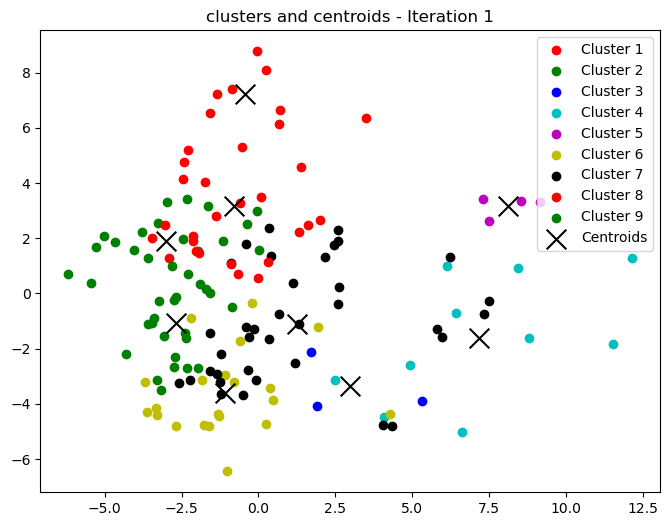

accuracy: 68.25%
F1 score: 0.67
confusion matrix:
[[28  7]
 [13 15]]


In [95]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Musk (Version 2)

In [27]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["musk2"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/75/data.csv
training set size: (4618, 166)
testing set size: (1980, 166)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;30]
predicted accuracy for k=2: 84.63%
predicted accuracy for k=3: 84.63%
predicted accuracy for k=4: 84.63%
predicted accuracy for k=5: 84.63%
predicted accuracy for k=6: 84.63%
predicted accuracy for k=7: 84.63%
predicted accuracy for k=8: 84.63%
predicted accuracy for k=9: 84.75%
predicted accuracy for k=10: 84.99%
predicted accuracy for k=11: 84.73%
predicted accuracy for k=12: 84.97%
predicted accuracy for k=13: 85.04%
predicted accuracy for k=14: 85.47%
predicted accuracy for k=15: 84.95%
predicted accuracy for k=16: 84.69%
predicted accuracy for k=17: 85.79%
predicted accuracy for k=18: 85.49%
predicted accuracy for k=19: 85.86%
predicted accuracy for k=20: 87.35%
predicted accuracy for k=21: 87.03%
predicted accuracy for k=22: 86.77%
predicted accuracy for k=23: 85.77%
predicted accuracy for k=24: 85.73%
predicted accuracy for k=25: 86.40%
predicted accuracy for k=26: 87.03%
predicted accuracy for k=27: 88.91%
predicted accuracy for k=28: 87.05%
pre

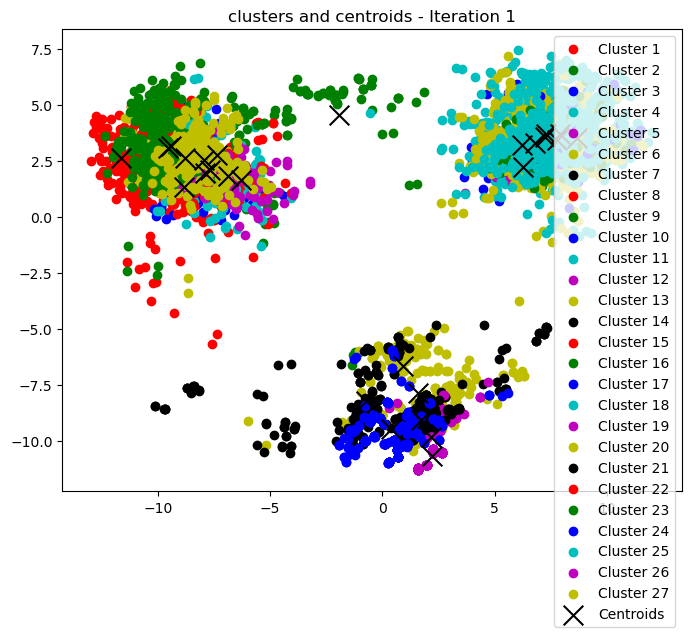

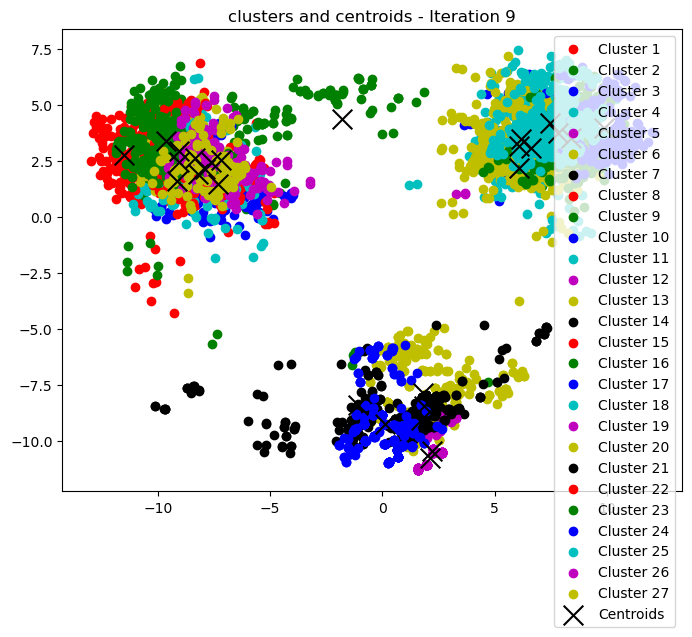

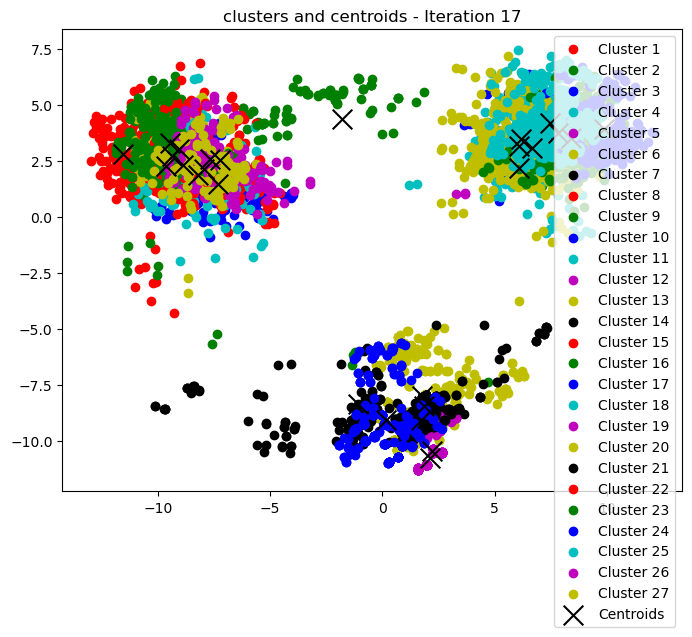

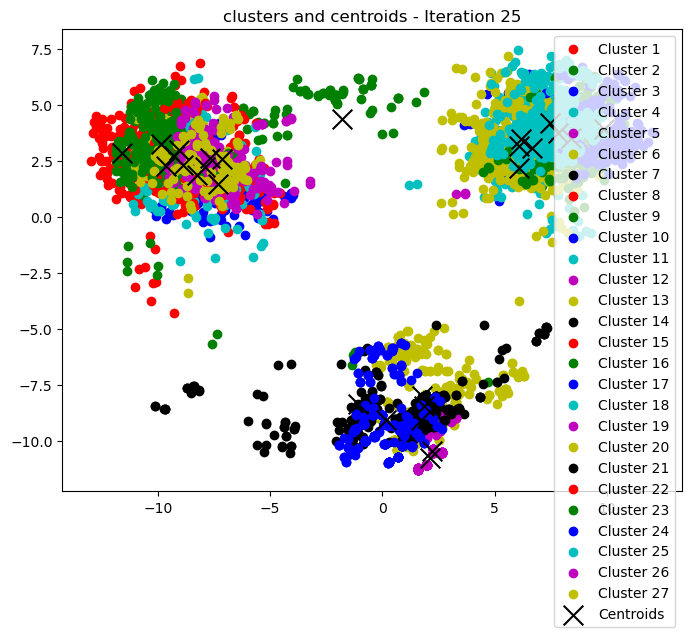

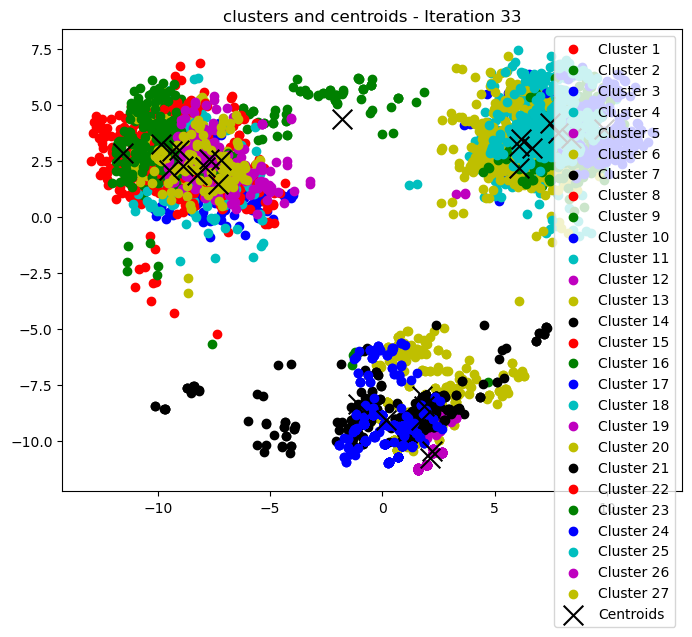

accuracy: 84.90%
F1 score: 0.68
confusion matrix:
[[1556  117]
 [ 182  125]]


In [28]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Breast Cancer Wisconsin (Diagnostic)

In [29]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["bc-wisc-diag"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/17/data.csv
training set size: (398, 30)
testing set size: (171, 30)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;16]
predicted accuracy for k=2: 90.72%
predicted accuracy for k=3: 87.19%
predicted accuracy for k=4: 89.20%
predicted accuracy for k=5: 86.93%
predicted accuracy for k=6: 92.22%
predicted accuracy for k=7: 92.46%
predicted accuracy for k=8: 93.72%
predicted accuracy for k=9: 93.97%
predicted accuracy for k=10: 91.47%
predicted accuracy for k=11: 93.23%
predicted accuracy for k=12: 92.72%
predicted accuracy for k=13: 93.22%
predicted accuracy for k=14: 94.48%
predicted accuracy for k=15: 92.72%
predicted accuracy for k=16: 92.97%
the best value of k is 14


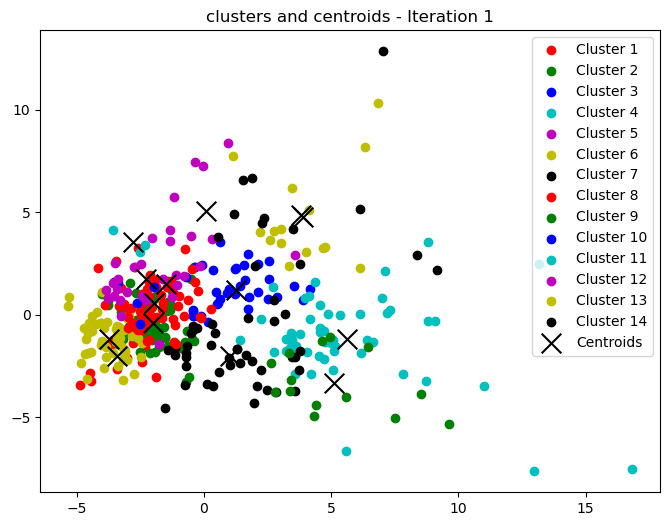

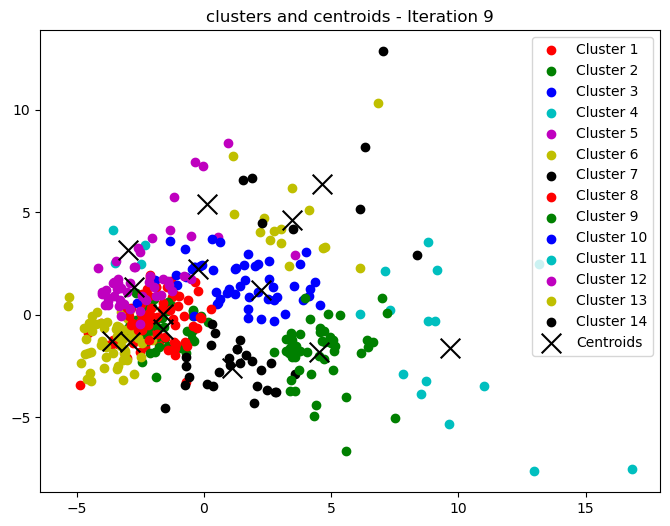

accuracy: 94.15%
F1 score: 0.94
confusion matrix:
[[106   2]
 [  8  55]]


In [30]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Balance-scale

In [31]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["balance-scale"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/12/data.csv
training set size: (437, 4)
testing set size: (188, 4)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;17]
predicted accuracy for k=2: 64.74%
predicted accuracy for k=3: 66.83%
predicted accuracy for k=4: 68.41%
predicted accuracy for k=5: 70.26%
predicted accuracy for k=6: 74.83%
predicted accuracy for k=7: 73.93%
predicted accuracy for k=8: 83.28%
predicted accuracy for k=9: 77.80%
predicted accuracy for k=10: 83.51%
predicted accuracy for k=11: 79.84%
predicted accuracy for k=12: 81.22%
predicted accuracy for k=13: 82.82%
predicted accuracy for k=14: 80.54%
predicted accuracy for k=15: 81.44%
predicted accuracy for k=16: 79.39%
predicted accuracy for k=17: 81.21%
the best value of k is 10


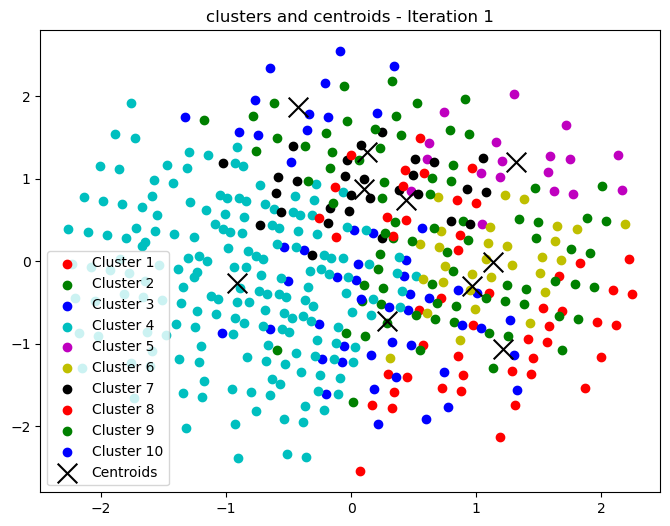

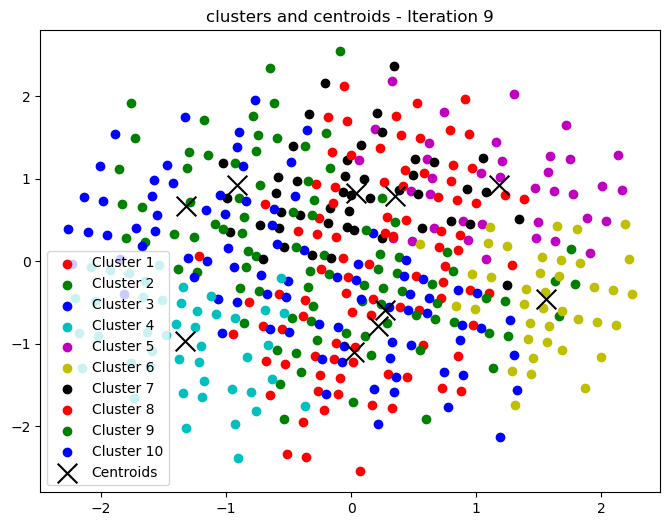

accuracy: 80.32%
F1 score: 0.56
confusion matrix:
[[ 0  9  9]
 [ 0 77  3]
 [ 0 16 74]]


In [33]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Contraception

In [34]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["contraception"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/30/data.csv
training set size: (1031, 9)
testing set size: (442, 9)


In [ ]:
print_useful_data(X, X_names, y, y_name)

In [43]:
#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, 75, visualization = False)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

accuracy: 60.86%
F1 score: 0.58
confusion matrix:
[[154  19  21]
 [ 41  48  12]
 [ 65  15  67]]


### Fertility

In [44]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["fertility"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/244/data.csv
training set size: (70, 9)
testing set size: (30, 9)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 87.14%
predicted accuracy for k=3: 87.14%
predicted accuracy for k=4: 87.14%
predicted accuracy for k=5: 88.57%
predicted accuracy for k=6: 87.14%
predicted accuracy for k=7: 90.00%
predicted accuracy for k=8: 91.43%
predicted accuracy for k=9: 90.00%
predicted accuracy for k=10: 92.86%
the best value of k is 10


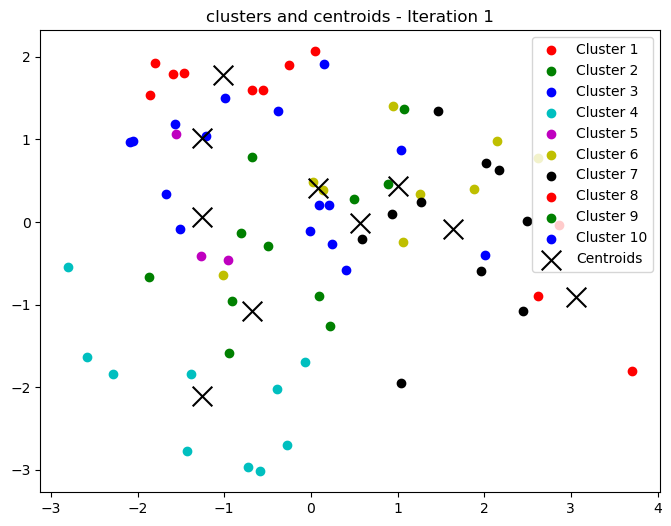

accuracy: 93.33%
F1 score: 0.73
confusion matrix:
[[27  0]
 [ 2  1]]


In [45]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Waveform (Version 1)

In [102]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["waveform"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/107/data.csv
training set size: (3500, 21)
testing set size: (1500, 21)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;30]
predicted accuracy for k=2: 63.23%
predicted accuracy for k=3: 53.97%
predicted accuracy for k=4: 65.80%
predicted accuracy for k=5: 73.43%
predicted accuracy for k=6: 72.06%
predicted accuracy for k=7: 75.29%
predicted accuracy for k=8: 74.00%
predicted accuracy for k=9: 74.94%
predicted accuracy for k=10: 74.74%
predicted accuracy for k=11: 76.14%
predicted accuracy for k=12: 76.46%
predicted accuracy for k=13: 76.83%
predicted accuracy for k=14: 77.60%
predicted accuracy for k=15: 76.63%
predicted accuracy for k=16: 76.29%
predicted accuracy for k=17: 76.69%
predicted accuracy for k=18: 77.43%
predicted accuracy for k=19: 77.29%
predicted accuracy for k=20: 76.71%
predicted accuracy for k=21: 77.37%
predicted accuracy for k=22: 76.54%
predicted accuracy for k=23: 77.66%
predicted accuracy for k=24: 77.43%
predicted accuracy for k=25: 78.06%
predicted accuracy for k=26: 77.20%
predicted accuracy for k=27: 78.09%
predicted accuracy for k=28: 77.94%
pre

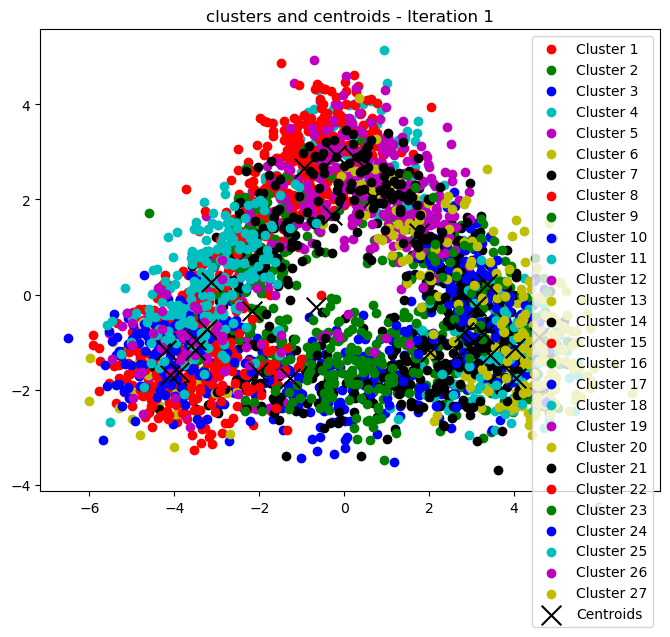

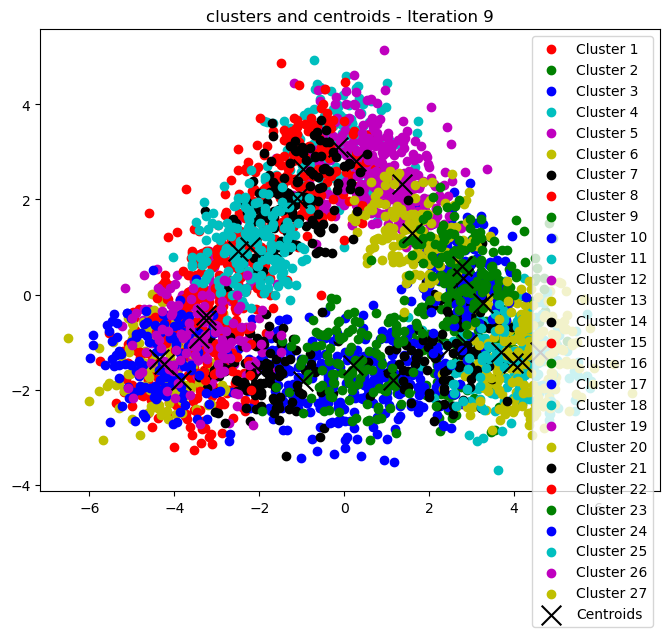

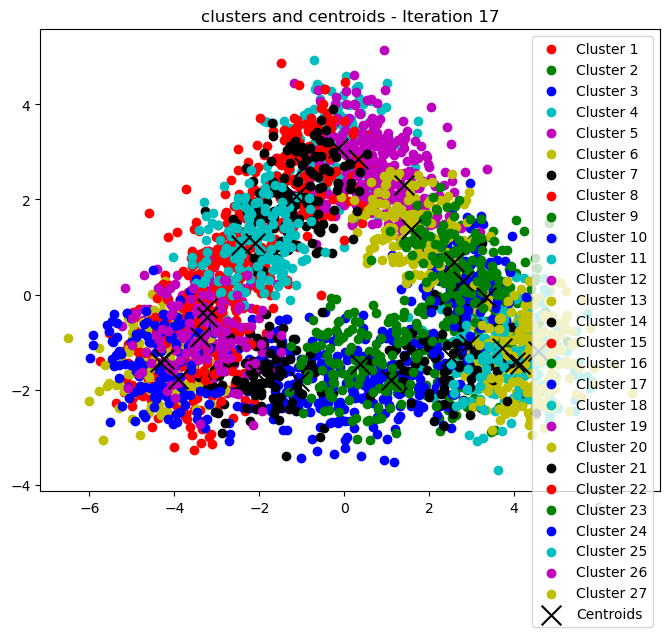

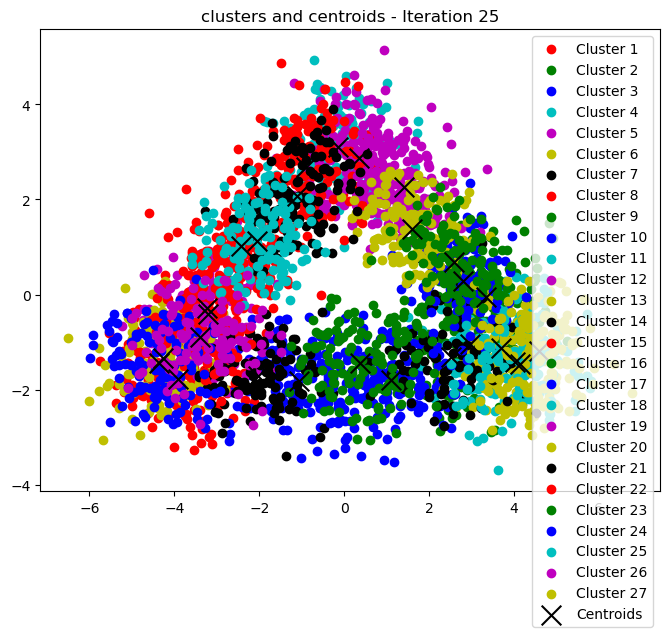

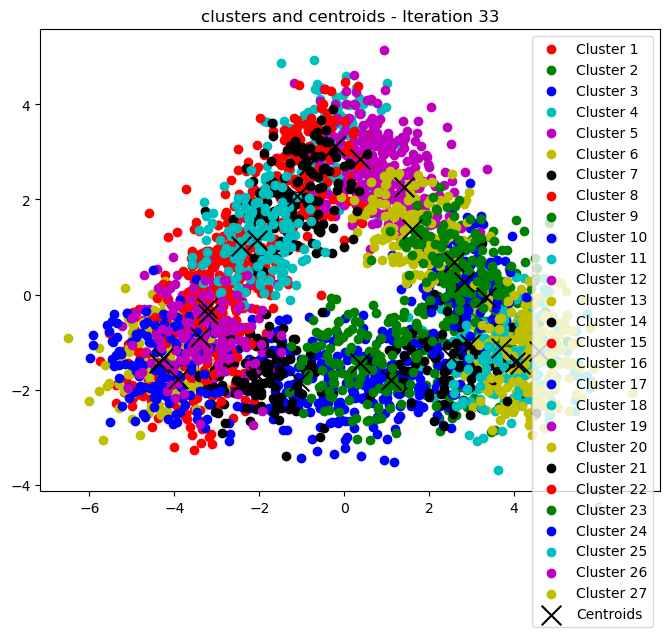

accuracy: 78.27%
F1 score: 0.78
confusion matrix:
[[392  34  71]
 [ 86 381  27]
 [ 46  62 401]]


In [105]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Image Segmentation

In [45]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["image-segmentation"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/50/data.csv
training set size: (147, 19)
testing set size: (63, 19)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 44.23%
predicted accuracy for k=3: 50.39%
predicted accuracy for k=4: 55.13%
predicted accuracy for k=5: 61.31%
predicted accuracy for k=6: 70.21%
predicted accuracy for k=7: 72.80%
predicted accuracy for k=8: 72.80%
predicted accuracy for k=9: 76.28%
predicted accuracy for k=10: 74.21%
the best value of k is 9


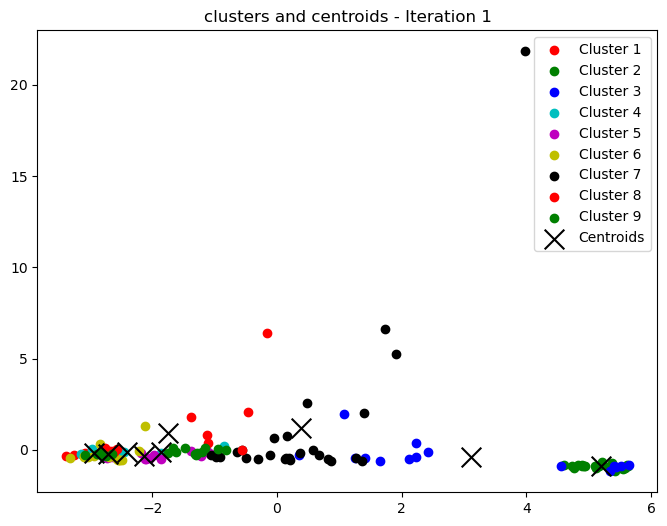

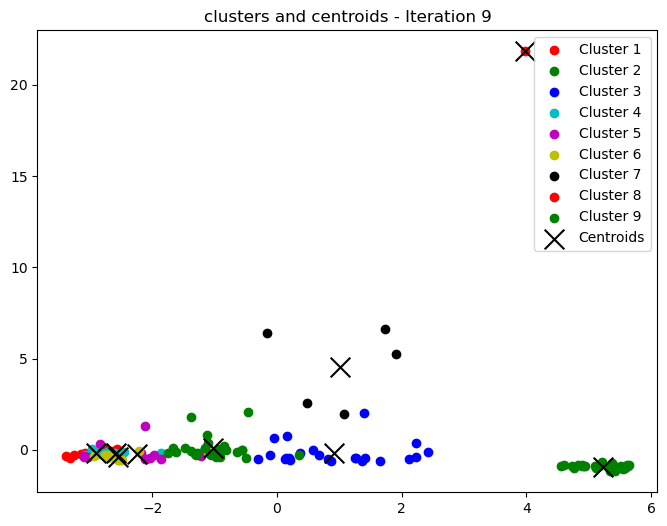

accuracy: 100.00%
F1 score: 1.00
confusion matrix:
[[30  0  0]
 [ 0 30  0]
 [ 0  0  3]]


In [46]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Blood Transfusion Service

In [33]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["blood"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/176/data.csv
training set size: (523, 4)
testing set size: (225, 4)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;19]
predicted accuracy for k=2: 74.21%
predicted accuracy for k=3: 75.16%
predicted accuracy for k=4: 75.16%
predicted accuracy for k=5: 75.35%
predicted accuracy for k=6: 75.16%
predicted accuracy for k=7: 76.31%
predicted accuracy for k=8: 76.50%
predicted accuracy for k=9: 78.61%
predicted accuracy for k=10: 76.88%
predicted accuracy for k=11: 78.41%
predicted accuracy for k=12: 78.80%
predicted accuracy for k=13: 78.79%
predicted accuracy for k=14: 79.56%
predicted accuracy for k=15: 79.36%
predicted accuracy for k=16: 79.17%
predicted accuracy for k=17: 80.13%
predicted accuracy for k=18: 79.94%
predicted accuracy for k=19: 79.56%
the best value of k is 17


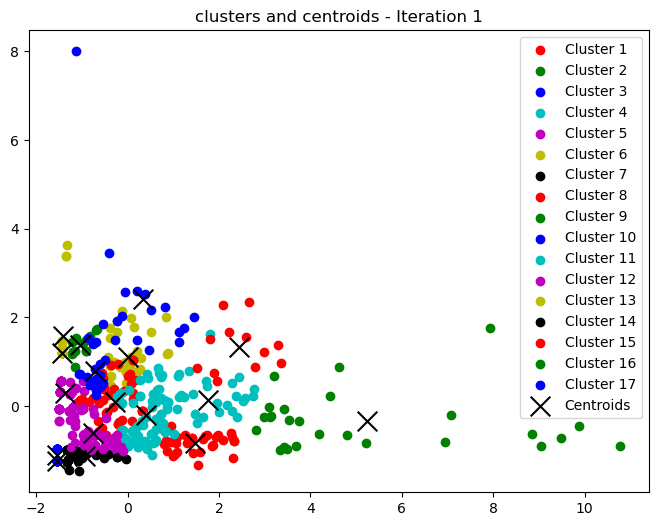

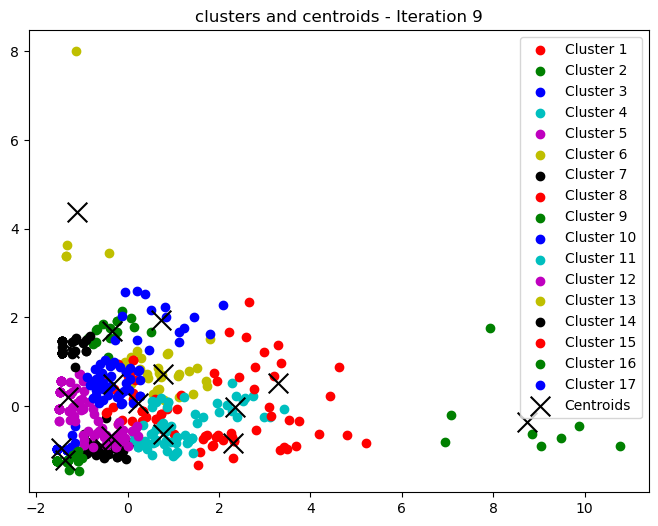

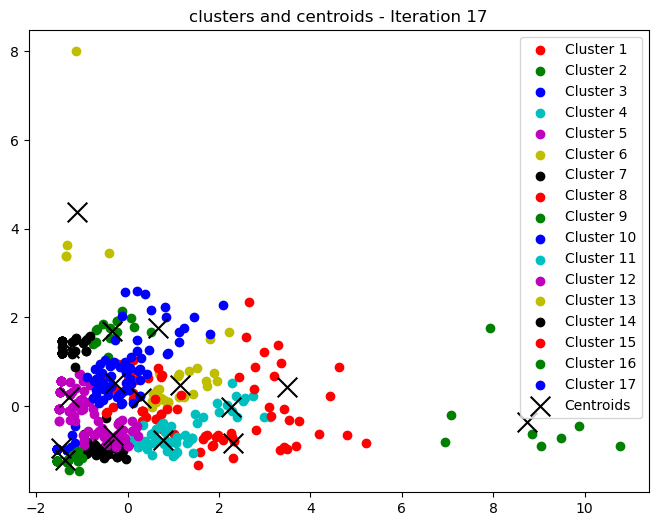

accuracy: 80.89%
F1 score: 0.45
confusion matrix:
[[182   0]
 [ 43   0]]


In [34]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### SPECT Heart

In [35]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["spect"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/95/data.csv
training set size: (186, 22)
testing set size: (81, 22)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;11]
predicted accuracy for k=2: 78.48%
predicted accuracy for k=3: 79.02%
predicted accuracy for k=4: 78.48%
predicted accuracy for k=5: 80.10%
predicted accuracy for k=6: 79.56%
predicted accuracy for k=7: 82.26%
predicted accuracy for k=8: 82.26%
predicted accuracy for k=9: 83.34%
predicted accuracy for k=10: 85.50%
predicted accuracy for k=11: 82.80%
the best value of k is 10


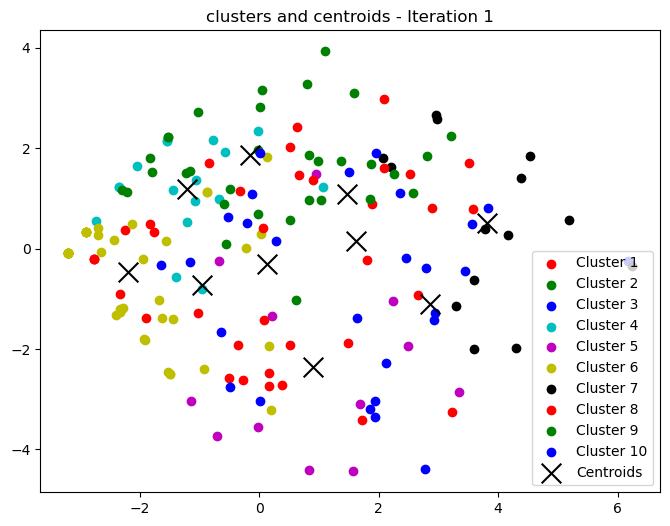

accuracy: 81.48%
F1 score: 0.45
confusion matrix:
[[ 0 15]
 [ 0 66]]


In [36]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Statlog (Landsat Satellite)

In [37]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["landsat"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/146/data.csv
training set size: (4504, 36)
testing set size: (1931, 36)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;30]
predicted accuracy for k=2: 39.68%
predicted accuracy for k=3: 52.31%
predicted accuracy for k=4: 61.39%
predicted accuracy for k=5: 67.27%
predicted accuracy for k=6: 74.73%
predicted accuracy for k=7: 76.20%
predicted accuracy for k=8: 78.62%
predicted accuracy for k=9: 80.59%
predicted accuracy for k=10: 80.08%
predicted accuracy for k=11: 81.06%
predicted accuracy for k=12: 81.64%
predicted accuracy for k=13: 81.51%
predicted accuracy for k=14: 81.11%
predicted accuracy for k=15: 81.15%
predicted accuracy for k=16: 82.33%
predicted accuracy for k=17: 82.19%
predicted accuracy for k=18: 82.90%
predicted accuracy for k=19: 82.48%
predicted accuracy for k=20: 82.53%
predicted accuracy for k=21: 83.41%
predicted accuracy for k=22: 83.41%
predicted accuracy for k=23: 83.30%
predicted accuracy for k=24: 83.46%
predicted accuracy for k=25: 83.75%
predicted accuracy for k=26: 84.44%
predicted accuracy for k=27: 84.32%
predicted accuracy for k=28: 84.08%
pre

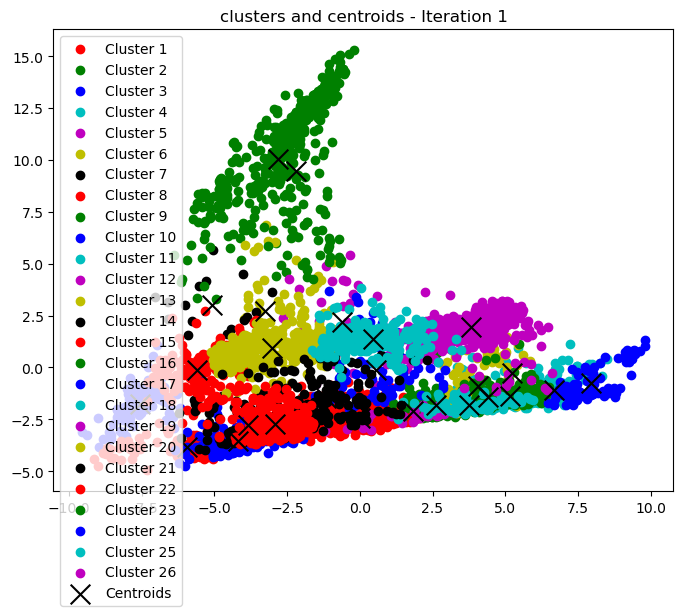

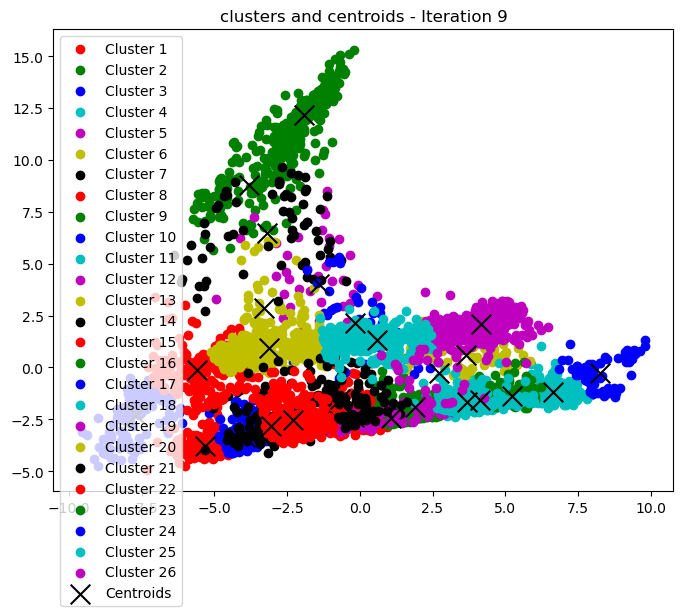

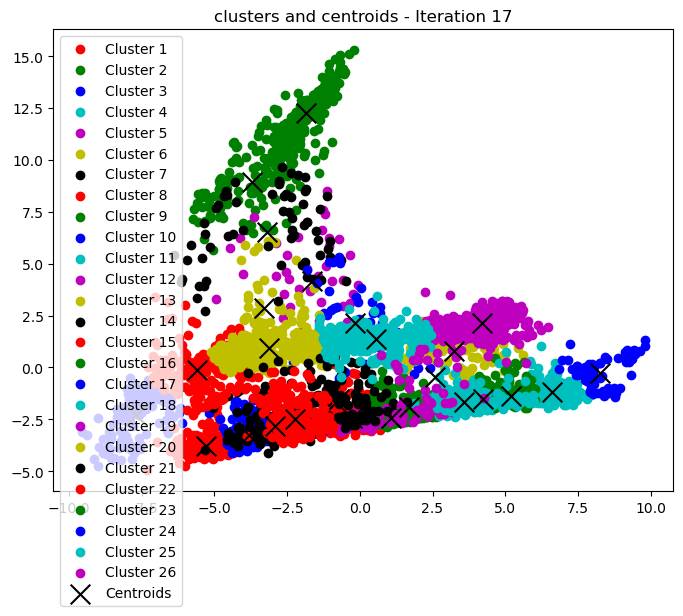

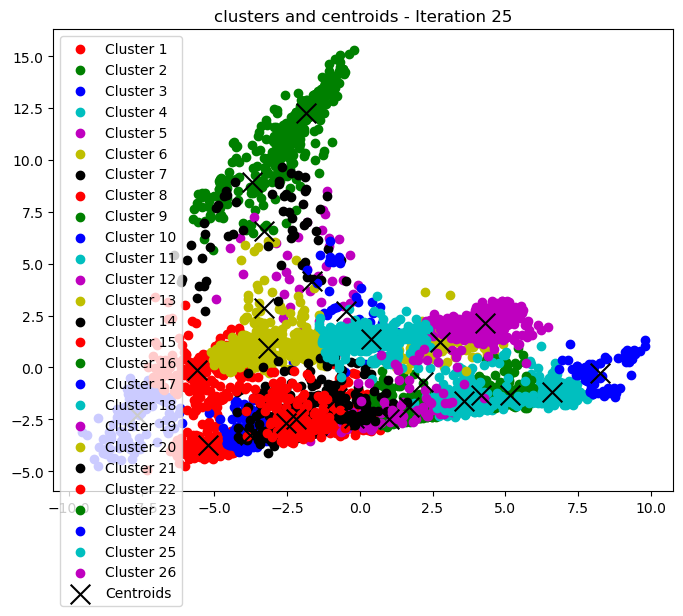

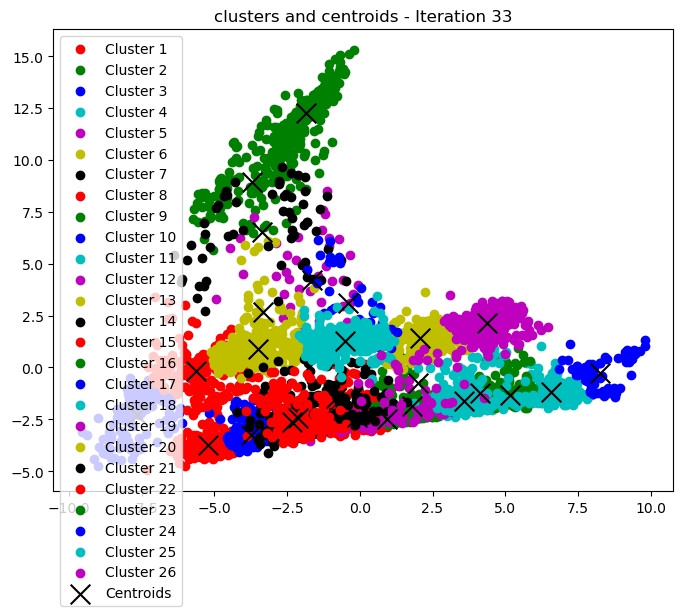

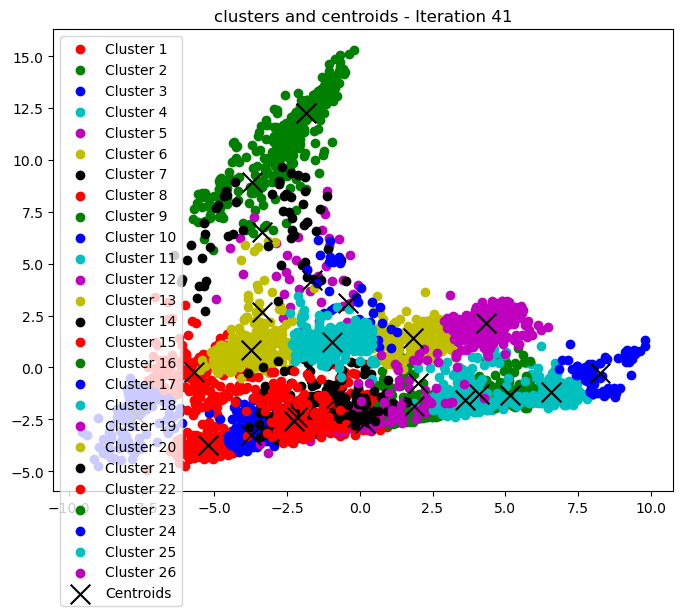

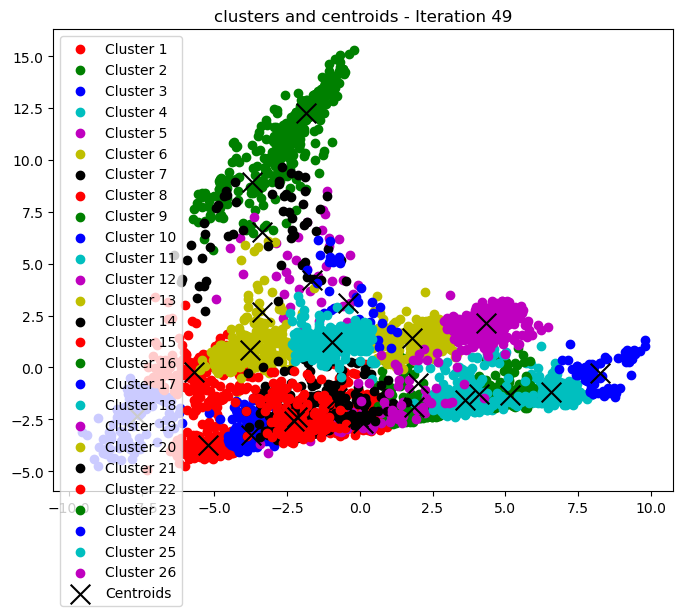

accuracy: 84.10%
F1 score: 0.82
confusion matrix:
[[442   2  13   0   2   2]
 [  2 219   0   1   1   1]
 [  1   2 327  26   0   9]
 [  0   1  22 125   0  36]
 [ 42   8   3   2 127  51]
 [  1   1  10  64   4 384]]


In [38]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Yeast

In [39]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["yeast"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/110/data.csv
training set size: (1038, 8)
testing set size: (446, 8)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;27]
predicted accuracy for k=2: 40.08%
predicted accuracy for k=3: 41.71%
predicted accuracy for k=4: 44.22%
predicted accuracy for k=5: 45.56%
predicted accuracy for k=6: 47.49%
predicted accuracy for k=7: 51.63%
predicted accuracy for k=8: 53.56%
predicted accuracy for k=9: 52.50%
predicted accuracy for k=10: 53.94%
predicted accuracy for k=11: 54.62%
predicted accuracy for k=12: 55.68%
predicted accuracy for k=13: 55.39%
predicted accuracy for k=14: 56.26%
predicted accuracy for k=15: 57.03%
predicted accuracy for k=16: 56.35%
predicted accuracy for k=17: 58.18%
predicted accuracy for k=18: 58.19%
predicted accuracy for k=19: 58.76%
predicted accuracy for k=20: 58.28%
predicted accuracy for k=21: 58.18%
predicted accuracy for k=22: 58.38%
predicted accuracy for k=23: 60.69%
predicted accuracy for k=24: 58.86%
predicted accuracy for k=25: 60.01%
predicted accuracy for k=26: 60.11%
predicted accuracy for k=27: 61.07%
the best value of k is 27


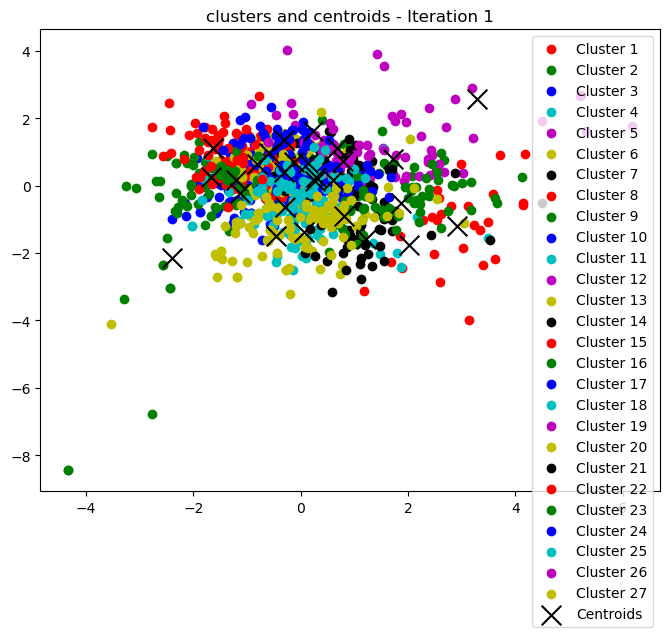

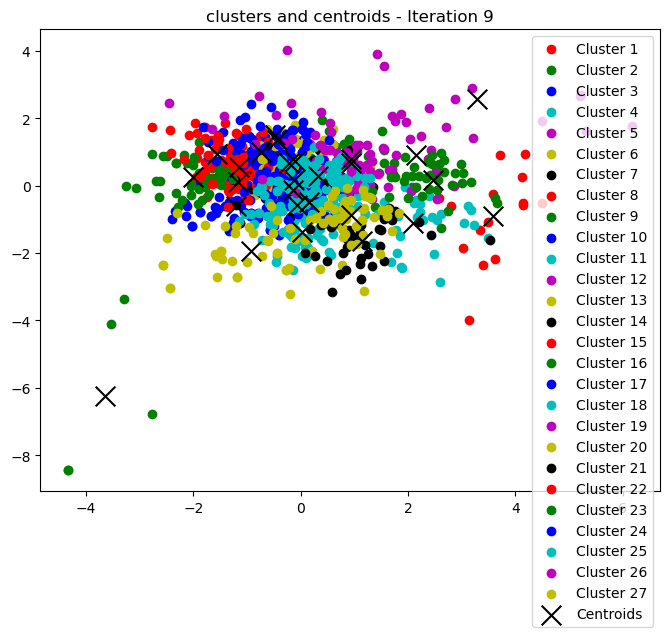

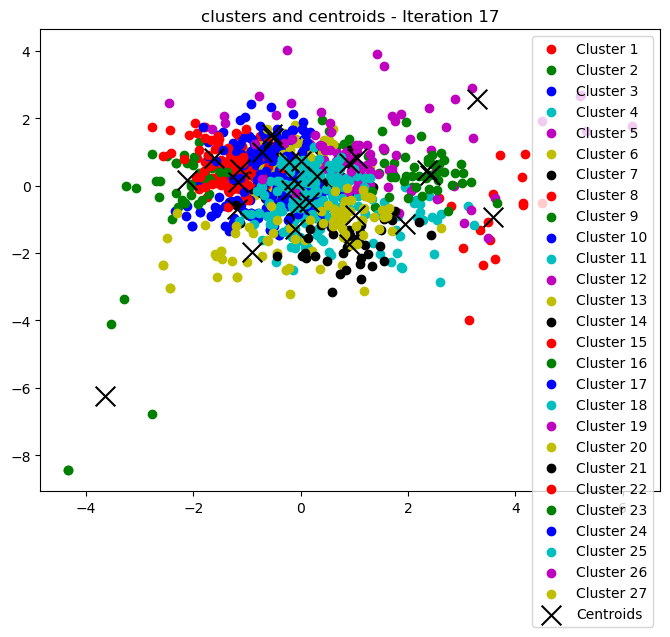

accuracy: 60.76%
F1 score: 0.50
confusion matrix:
[[104   2   0   0   4   5  32   0   0]
 [  0   6   2   0   0   1   0   0   0]
 [  0   3  21   0   0   0   0   0   0]
 [  4   1   6   1   2   1   0   0   0]
 [  4   0   2   1  59   0   7   0   0]
 [ 12   0   0   0   3  14   6   0   0]
 [ 48   0   1   0   6   4  63   0   0]
 [  0   1   1   0   0   0   0   3   0]
 [  8   1   2   0   3   0   2   0   0]]


In [40]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Monk

In [46]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["monk"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/70/data.csv
training set size: (302, 6)
testing set size: (130, 6)


In [ ]:
print_useful_data(X, X_names, y, y_name)

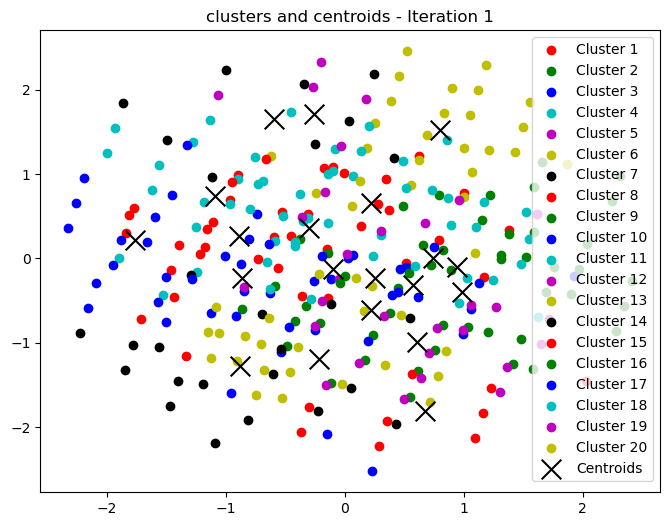

accuracy: 68.46%
F1 score: 0.68
confusion matrix:
[[49 12]
 [29 40]]


In [52]:
#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, 20)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Ecoli

In [41]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["ecoli"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/39/data.csv
training set size: (235, 7)
testing set size: (101, 7)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;12]
predicted accuracy for k=2: 82.55%
predicted accuracy for k=3: 89.36%
predicted accuracy for k=4: 89.79%
predicted accuracy for k=5: 88.51%
predicted accuracy for k=6: 89.36%
predicted accuracy for k=7: 89.36%
predicted accuracy for k=8: 90.64%
predicted accuracy for k=9: 89.79%
predicted accuracy for k=10: 90.21%
predicted accuracy for k=11: 90.64%
predicted accuracy for k=12: 90.21%
the best value of k is 8


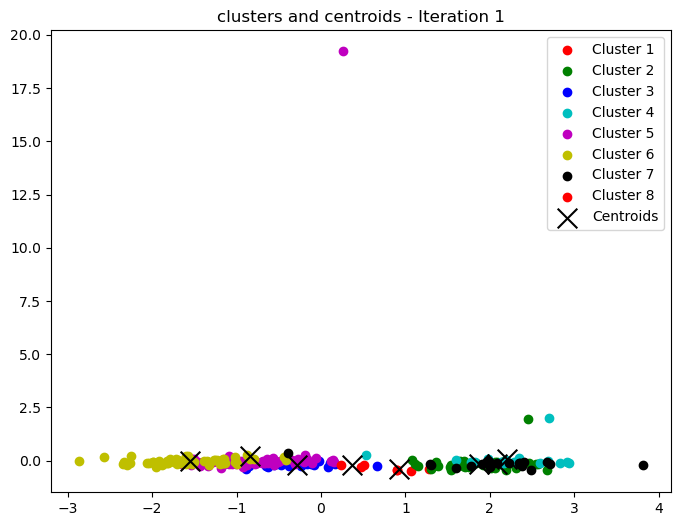

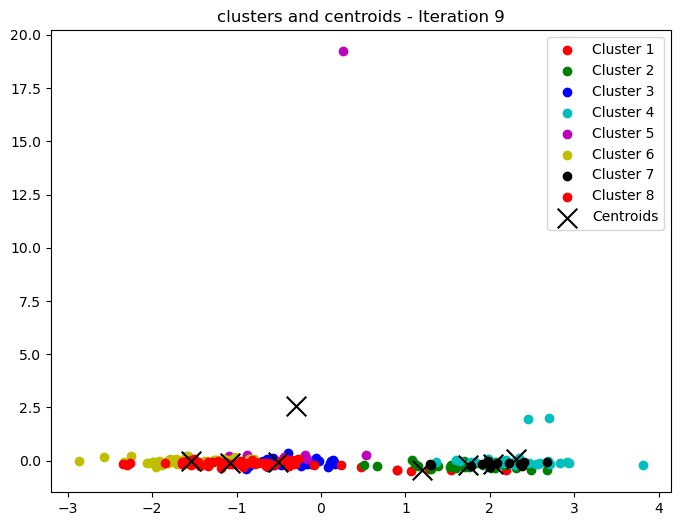

accuracy: 83.17%
F1 score: 0.62
confusion matrix:
[[24  0  0  0]
 [ 4 14  0  2]
 [ 4  0  0  1]
 [ 3  3  0 46]]


In [42]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Iris

In [53]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["iris"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/53/data.csv
training set size: (105, 4)
testing set size: (45, 4)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 72.38%
predicted accuracy for k=3: 83.81%
predicted accuracy for k=4: 83.81%
predicted accuracy for k=5: 84.76%
predicted accuracy for k=6: 87.62%
predicted accuracy for k=7: 88.57%
predicted accuracy for k=8: 89.52%
predicted accuracy for k=9: 90.48%
predicted accuracy for k=10: 94.29%
the best value of k is 10


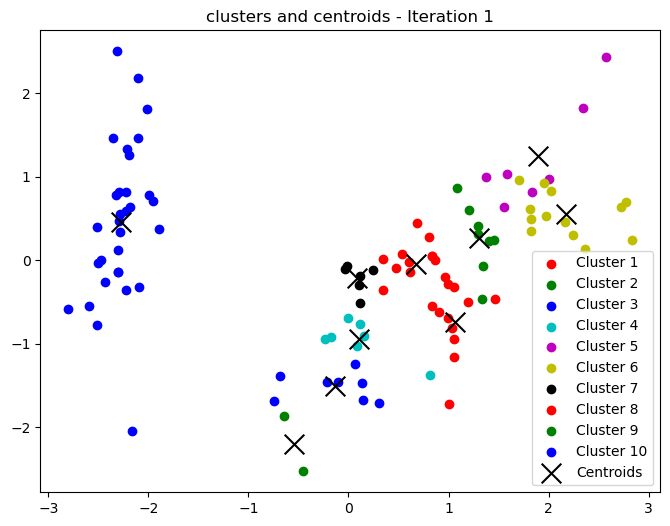

accuracy: 91.11%
F1 score: 0.90
confusion matrix:
[[19  0  0]
 [ 0 10  3]
 [ 0  1 12]]


In [54]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Zoo

In [43]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["zoo"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/111/data.csv
training set size: (70, 16)
testing set size: (31, 16)


In [ ]:
print_useful_data(X, X_names, y, y_name)

range of k values tested: [2;10]
predicted accuracy for k=2: 65.71%
predicted accuracy for k=3: 74.29%
predicted accuracy for k=4: 78.57%
predicted accuracy for k=5: 82.86%
predicted accuracy for k=6: 90.00%
predicted accuracy for k=7: 87.14%
predicted accuracy for k=8: 88.57%
predicted accuracy for k=9: 91.43%
predicted accuracy for k=10: 92.86%
the best value of k is 10


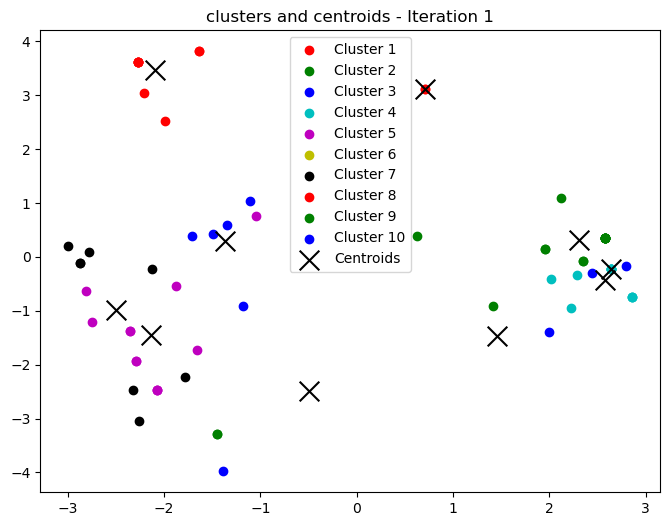

accuracy: 87.10%
F1 score: 0.65
confusion matrix:
[[8 0 0 0 0 0 0]
 [0 7 0 0 0 0 0]
 [0 1 3 0 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 2]
 [0 0 0 0 0 0 5]]


In [44]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")